## Library

In [1]:
import os
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
from datetime import datetime as dt
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 5000                                       # Number of runs to do (default 10000)
CURRENT_YEAR = 2023                               # What year to start the run on? (default: 2023)
MAX_YEAR = CURRENT_YEAR + 100                     # What year to end the run on? (default: 2123)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/pasta')  # Cache generated in "Anchors" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/pasta.sqcache.npy'))))
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

Cache from: 2023-07-09 21:08:13.276039


{1: 23.4,
 5: 24.7,
 10: 25.4,
 20: 26.3,
 30: 27.1,
 40: 27.9,
 50: 29.4,
 60: 31.1,
 70: 33.1,
 80: 35.5,
 90: 38.9,
 95: 41.7,
 99: 47.301000000000016}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "Initial pay" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/initial_pay.sqcache.npy'))))
initial_pay = [round(p, 1) for p in initial_pay]
# TODO: Suspicious this is not working in the model correctly
sq.get_percentiles(initial_pay)

Cache from: 2023-07-09 21:15:00.888206


{1: 8.0,
 5: 8.2,
 10: 8.3,
 20: 8.4,
 30: 8.5,
 40: 8.6,
 50: 8.7,
 60: 8.7,
 70: 8.8,
 80: 8.9,
 90: 9.1,
 95: 9.2,
 99: 9.6}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/nonscaling_delays.dill'))))

delay

Cache from: 2023-09-05 17:35:37.520277


{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=4.37, lognorm_sd=1.93, norm_mean=1.39, norm_sd=0.42)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=9.15, lognorm_sd=5.75, norm_mean=2.05, norm_sd=0.58)},
 'infra': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=2.52, lognorm_sd=1.31, norm_mean=0.8, norm_sd=0.49)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=12.12, lognorm_sd=9.64, norm_mean=2.25, norm_sd=0.7)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.45, lognorm_sd=2.42, norm_mean=1.04, norm_sd=0.63)
   - 0.1 weight on <Distribution> lo

In [6]:
def wildeford_max_gdp_frac():
    small_project = sq.lognorm(1 / (4*K), 1 / (1*K))
    modern_megaproject = sq.lognorm(1/K, 1/600)
    old_form_megaproject = sq.lognorm(1/K, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.1:
        gdp_frac = small_project
        percent_spent_on_compute = sq.lognorm(0.5, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.7:
        gdp_frac = modern_megaproject
        percent_spent_on_compute = sq.lognorm(0.7, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.9:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.95, lclip=0.1, rclip=0.999)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.99, lclip=0.1, rclip=0.999)
        
    models_trained_per_year_for_budget = sq.lognorm(1, 10)

    frac = ~gdp_frac * ~percent_spent_on_compute / ~models_trained_per_year_for_budget
    
    return (1 / (4*K)) if frac < (1 / (4*K)) else frac


# https://forum.effectivealtruism.org/posts/ccw9v9giKxg8nyLhp/xpt-forecasts-on-some-biological-anchors-inputs
variables = {'initial_gdp': 23*T,
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': 3,
             'algo_doubling_rate_min': 1,
             'min_reduction': 2,
             'max_reduction': sq.lognorm(3, 15),
             'initial_flop_per_dollar': sq.lognorm(18, 19.2),
             'flop_halving_rate': sq.lognorm(1.4, 4.1),     # https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.lognorm(21, 26),  # https://epochai.org/blog/predicting-gpu-performance and https://asteriskmag.com/issues/03/the-transistor-cliff
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': wildeford_max_gdp_frac, # TODO: Willingness to spend connected to commercialization
             'spend_doubling_time': sq.lognorm(1, 8.5, lclip=0.9),
             '2025_spend_doubling_time': sq.norm(0.94, 1.02, lclip=0.9),
             'nonscaling_delay': delay}

print('Loaded')


Loaded


## GDP Frac

In [7]:
gdp_frac_samples = sq.sample(wildeford_max_gdp_frac, verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 1057725.32it/s]


{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00031,
 50: 0.00039,
 60: 0.00049,
 70: 0.00067,
 80: 0.001,
 90: 0.00205,
 95: 0.00389,
 99: 0.00998}

In [8]:
gdp_samples = [g * variables['initial_gdp'] for g in gdp_frac_samples]
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '6 billion',
 5: '6 billion',
 10: '6 billion',
 20: '6 billion',
 30: '6 billion',
 40: '7 billion',
 50: '9 billion',
 60: '11 billion',
 70: '15 billion',
 80: '23 billion',
 90: '47 billion',
 95: '89 billion',
 99: '230 billion'}

## Run Wildeford timelines model

-
-
## SAMPLE RUN 1 ##
It takes 28.2 log FLOP (~16 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.0 log FLOP (~1 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 26.0 log FLOP (~99 septillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~123 million). This doubles every 1.1 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 26.1 max log FLOP (133 septillion) available - TAI takes 28.2 log FLOP (16 octillion) - log $ 10.2 to buy TAI (14 billion) vs. willingness to pay log $ 8.1 (121 million) - 18.0 log FLOP per $ (1 quintillion) (Effective 2023-logFLOP: 26.1)
Year: 2024 - 26.5 max log FLOP (309 septillion) available - TAI takes 28.1 log FLOP (13 octillion) - log $ 10.0 to buy TAI (9 billion) vs. willingness to pay log $ 8.3 (222 million) - 18.1 log FLOP per $ (1 quintill

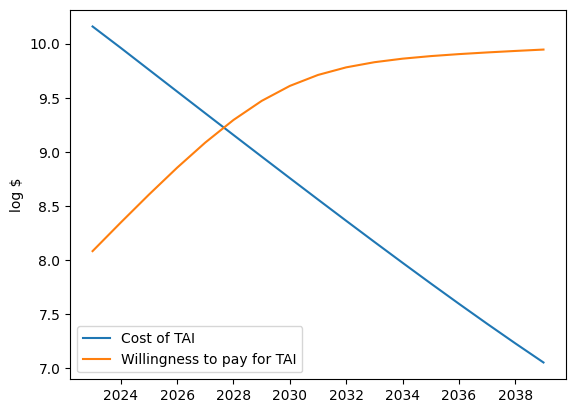

-
-
## SAMPLE RUN 2 ##
It takes 26.8 log FLOP (~631 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~5 quintillion) per 2022$USD. Every 3.4 years they get 2x cheaper, to a maximum of 25.4 log FLOP (~24 septillion) per 2022$USD.
We are initially willing to pay 9.1 log 2022$USD (~1 billion). This doubles every 9.2 years to a max of 0.042753% of GDP (initially ~10 billion 2022$USD). GDP grows at a rate of 1.016x per year.
---
Year: 2023 - 27.8 max log FLOP (6 octillion) available - TAI takes 26.8 log FLOP (631 septillion) - log $ 8.1 to buy TAI (129 million) vs. willingness to pay log $ 9.1 (1 billion) - 18.7 log FLOP per $ (5 quintillion) (Effective 2023-logFLOP: 27.8)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.

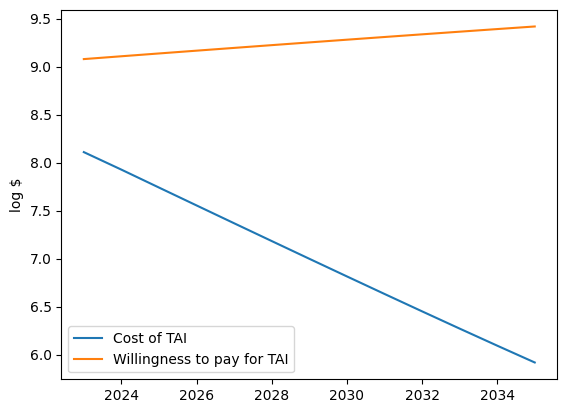

-
-
## SAMPLE RUN 3 ##
It takes 49.5 log FLOP (~32 quadrillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 3.1 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 21.4 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~241 million). This doubles every 1.9 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 27.0 max log FLOP (980 septillion) available - TAI takes 49.5 log FLOP (32 quadrillion decillion) - log $ 30.9 to buy TAI (7 nonillion) vs. willingness to pay log $ 8.4 (231 million) - 18.6 log FLOP per $ (4 quintillion) (Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 49.2 log FLOP (16 quadrillion decillion) - log $ 30.4 to buy TAI (3 nonillion) vs. willingness to pay log $ 8.5 (330 million

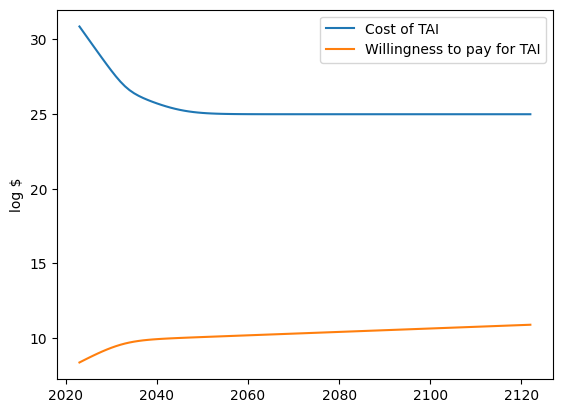

-
-
## RUN TIMELINES MODEL ##
Generating Bayes net with 5 cores...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:18<00:00, 265.44it/s]


Shuffling data...
Writing data...
Waiting for other cores...
.Collecting data...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 125.52it/s]

...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!
-
## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2031',
 '10%: 2033',
 '15%: 2034',
 '20%: 2036',
 '25%: 2037',
 '35%: 2040',
 '50%: 2043',
 '60%: 2048',
 '75%: 2060',
 '80%: 2069',
 '90%: >2123',
 '95%: >2123']
(Mean: 2056)
-
-
## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 8 years from now',
 '10%: 10 years from now',
 '15%: 11 years from now',
 '20%: 13 years from now',
 '25%: 14 years from now',
 '35%: 17 years from now',
 '50%: 20 years from now',
 '60%: 25 years from now',
 '75%: 37 years from now',
 '80%: 46 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
(Mean: 33 years from now)
-
-
## TAI ARRIVAL DATE BY BIN ##
This year: 0.0%
2024-2027: 0.2%
2028-2029: 1.7%
2030-2034: 13.6%
2035-2039: 19.1%
2040-2049: 28.5%
2050-2059: 11.3%
2060-2069: 5.6%
2070-2079: 4.0%
2080-2089: 1.4%
2090-2099: 0.9%
2100-2109: 0.

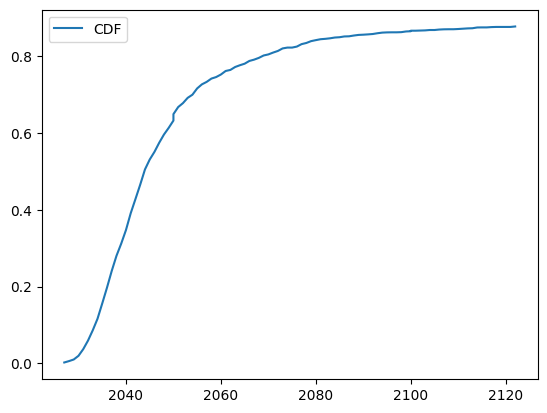

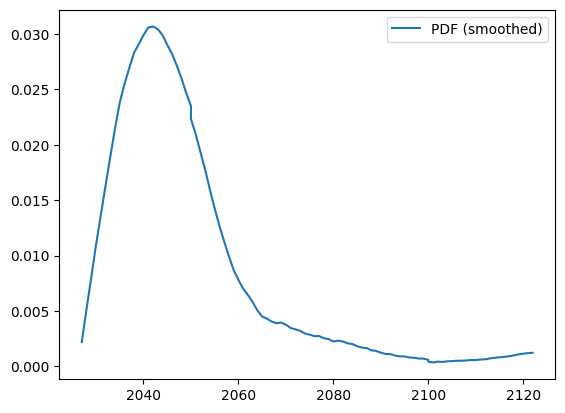

-
-
## TAI FLOP SIZE ##
{1: 23.1,
 5: 24.5,
 10: 25.3,
 20: 26.2,
 30: 27.1,
 40: 28.0,
 50: 29.5,
 60: 31.1,
 70: 33.0,
 80: 35.3,
 90: 38.9,
 95: 42.1,
 99: 49.2}
(Mean: 31.0)


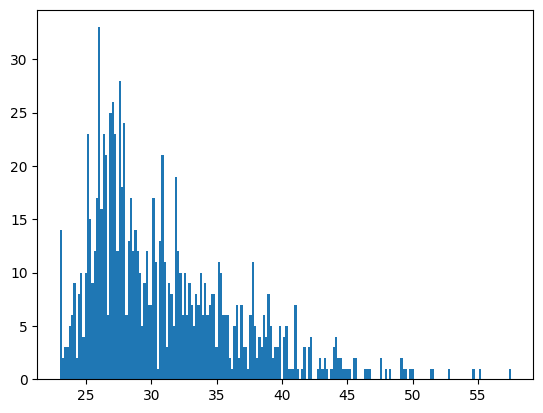

-
-
## MIN REDUCTION: 2 ##
-
## MAX REDUCTION ##
{1: 20.7,
 5: 15.5,
 10: 12.2,
 20: 10.1,
 30: 8.7,
 40: 7.7,
 50: 6.9,
 60: 6.0,
 70: 5.3,
 80: 4.5,
 90: 3.8,
 95: 3.1,
 99: 2.1}
(Mean: 7.6)


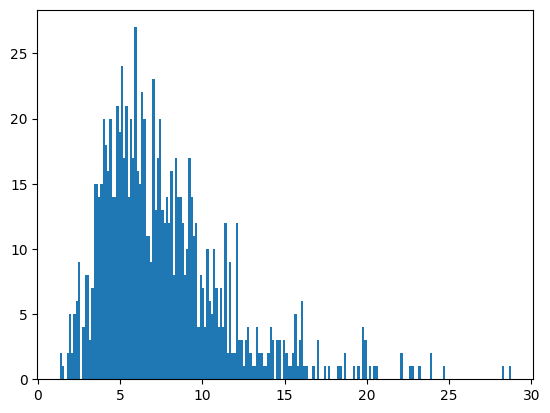

-
-
## MIN ALGO DOUBLING RATE: 1 ##
-
## MAX ALGO DOUBLING RATE: 3 ##
-
## INITIAL FLOP PER DOLLAR ##
{1: 17.7,
 5: 18.0,
 10: 18.2,
 20: 18.3,
 30: 18.4,
 40: 18.5,
 50: 18.6,
 60: 18.7,
 70: 18.8,
 80: 18.9,
 90: 19.0,
 95: 19.2,
 99: 19.4}
(Mean: 18.6)


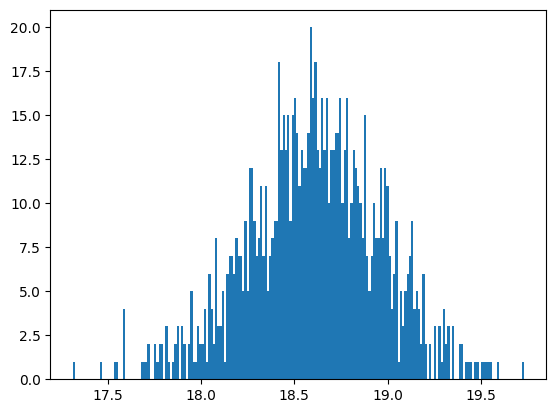

-
-
## FLOP HALVING RATE ##
{1: 5.3,
 5: 4.2,
 10: 3.6,
 20: 3.1,
 30: 2.8,
 40: 2.6,
 50: 2.4,
 60: 2.2,
 70: 2.0,
 80: 1.8,
 90: 1.6,
 95: 1.4,
 99: 1.2}
(Mean: 2.5)


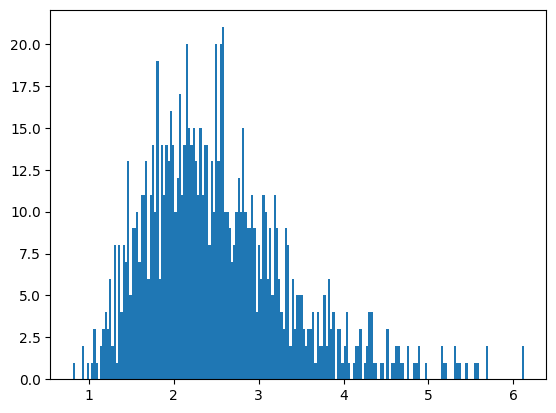

-
-
## MAX FLOP PER DOLLAR ##
{1: 20.0,
 5: 20.8,
 10: 21.4,
 20: 22.1,
 30: 22.6,
 40: 22.9,
 50: 23.4,
 60: 23.8,
 70: 24.3,
 80: 24.7,
 90: 25.4,
 95: 26.0,
 99: 27.0}
(Mean: 23.4)


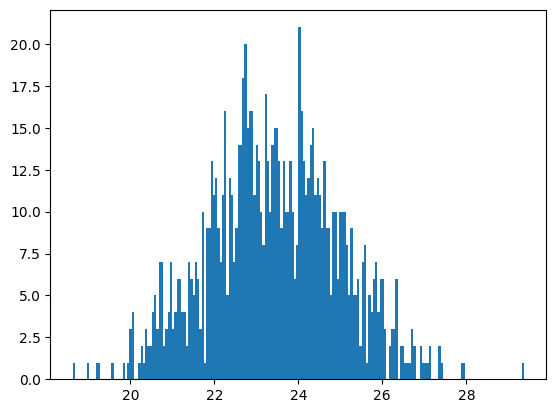

-
-
## INITIAL PAY ##
{1: 8.0,
 5: 8.2,
 10: 8.3,
 20: 8.4,
 30: 8.5,
 40: 8.6,
 50: 8.6,
 60: 8.7,
 70: 8.8,
 80: 8.9,
 90: 9.1,
 95: 9.2,
 99: 9.6}
(Mean: 8.7)


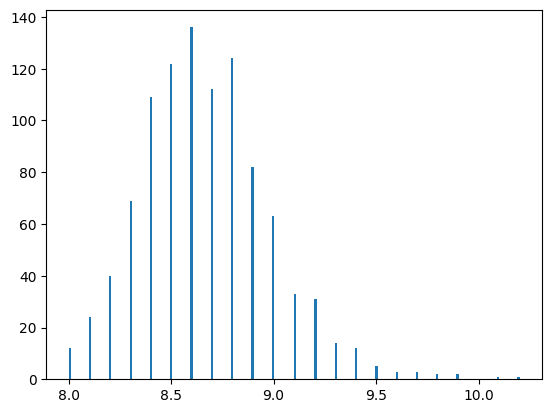

-
-
## GDP GROWTH ##
{1: 1.0,
 5: 1.01,
 10: 1.01,
 20: 1.02,
 30: 1.02,
 40: 1.02,
 50: 1.02,
 60: 1.02,
 70: 1.03,
 80: 1.03,
 90: 1.03,
 95: 1.04,
 99: 1.04}
(Mean: 1.0)


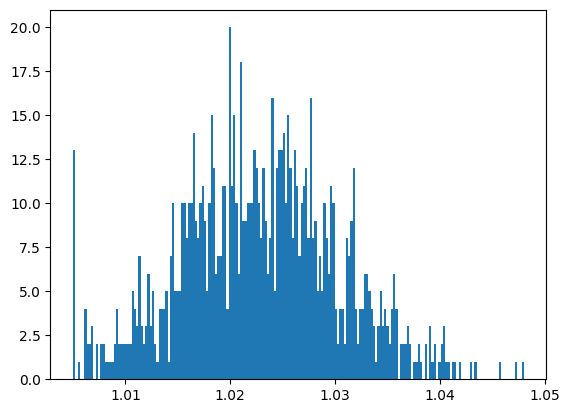

-
-
## MAX GDP FRAC ##
{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00031,
 50: 0.00038,
 60: 0.00051,
 70: 0.0007,
 80: 0.0011,
 90: 0.00229,
 95: 0.00415,
 99: 0.00889}
(Mean: 0.0)


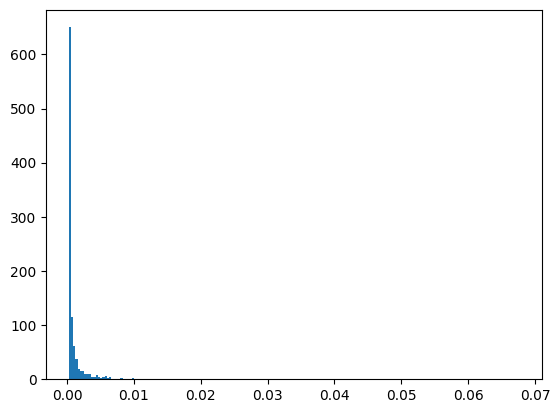

-
-
## SPEND DOUBLING TIME ##
{1: 14.2,
 5: 8.1,
 10: 6.5,
 20: 5.0,
 30: 4.2,
 40: 3.4,
 50: 2.9,
 60: 2.5,
 70: 2.1,
 80: 1.7,
 90: 1.3,
 95: 1.1,
 99: 0.9}
(Mean: 3.6)


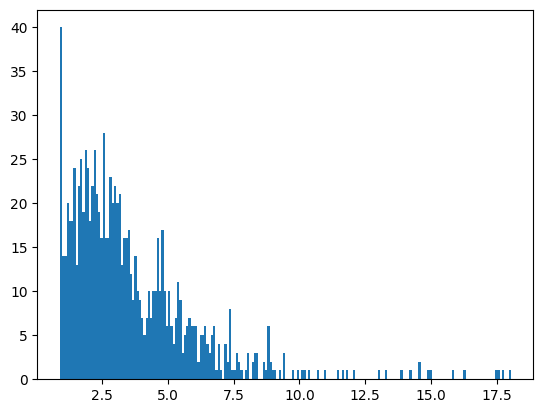

-
-
-
-
## GDP Over Time ##


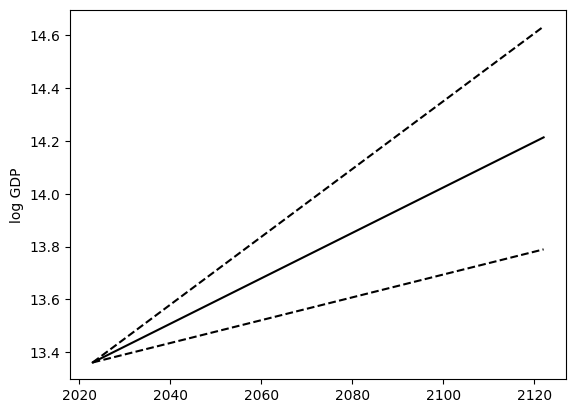

Year: 2023 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~23 trillion)
Year: 2024 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2025 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2026 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~25 trillion)
Year: 2027 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~26 trillion)
Year: 2028 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2029 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2030 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~28 trillion)
Year: 2031 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~29 trillion)
Year: 2032 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~30 trillion)
Year: 2033

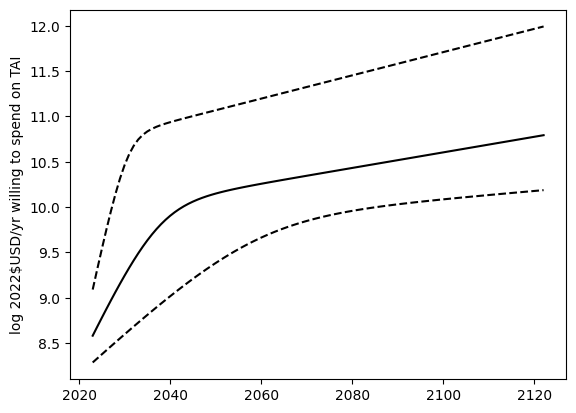

Year: 2023 - willingness log 2022$USD per year 8.6 (~381 million) 90% CI 8.3 (~193 million) - 9.1 (~1 billion)
Year: 2024 - willingness log 2022$USD per year 8.7 (~478 million) 90% CI 8.3 (~214 million) - 9.3 (~2 billion)
Year: 2025 - willingness log 2022$USD per year 8.8 (~600 million) 90% CI 8.4 (~237 million) - 9.5 (~3 billion)
Year: 2026 - willingness log 2022$USD per year 8.9 (~750 million) 90% CI 8.4 (~263 million) - 9.8 (~6 billion)
Year: 2027 - willingness log 2022$USD per year 9.0 (~933 million) 90% CI 8.5 (~291 million) - 10.0 (~9 billion)
Year: 2028 - willingness log 2022$USD per year 9.1 (~1 billion) 90% CI 8.5 (~322 million) - 10.1 (~14 billion)
Year: 2029 - willingness log 2022$USD per year 9.2 (~1 billion) 90% CI 8.6 (~356 million) - 10.3 (~21 billion)
Year: 2030 - willingness log 2022$USD per year 9.2 (~2 billion) 90% CI 8.6 (~394 million) - 10.5 (~29 billion)
Year: 2031 - willingness log 2022$USD per year 9.3 (~2 billion) 90% CI 8.6 (~436 million) - 10.6 (~38 billion)


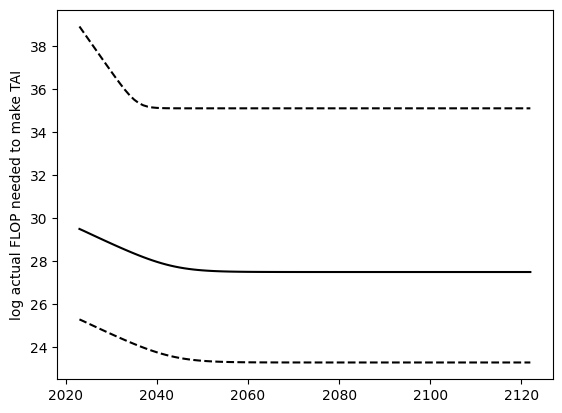

Year: 2023 - log FLOP needed for TAI 29.5 (~316 octillion) 90% CI 25.3 (~20 septillion) - 38.9 (~794 thousand decillion)
Year: 2024 - log FLOP needed for TAI 29.4 (~254 octillion) 90% CI 25.2 (~16 septillion) - 38.6 (~397 thousand decillion)
Year: 2025 - log FLOP needed for TAI 29.3 (~202 octillion) 90% CI 25.1 (~13 septillion) - 38.3 (~199 thousand decillion)
Year: 2026 - log FLOP needed for TAI 29.2 (~161 octillion) 90% CI 25.0 (~10 septillion) - 38.0 (~99 thousand decillion)
Year: 2027 - log FLOP needed for TAI 29.1 (~129 octillion) 90% CI 24.9 (~8 septillion) - 37.7 (~50 thousand decillion)
Year: 2028 - log FLOP needed for TAI 29.0 (~103 octillion) 90% CI 24.8 (~6 septillion) - 37.4 (~25 thousand decillion)
Year: 2029 - log FLOP needed for TAI 28.9 (~82 octillion) 90% CI 24.7 (~5 septillion) - 37.1 (~13 thousand decillion)
Year: 2030 - log FLOP needed for TAI 28.8 (~66 octillion) 90% CI 24.6 (~4 septillion) - 36.8 (~6 thousand decillion)
Year: 2031 - log FLOP needed for TAI 28.7 (~

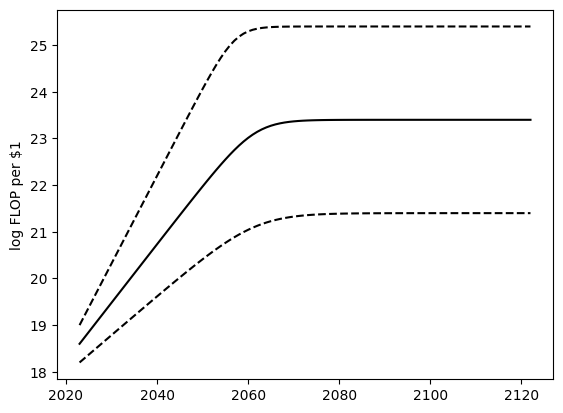

Year: 2023 - log FLOP per 2022$1USD 18.6 (~4 quintillion) 90% CI 18.2 (~2 quintillion) - 19.0 (~10 quintillion)
Year: 2024 - log FLOP per 2022$1USD 18.7 (~5 quintillion) 90% CI 18.3 (~2 quintillion) - 19.2 (~15 quintillion)
Year: 2025 - log FLOP per 2022$1USD 18.9 (~7 quintillion) 90% CI 18.4 (~2 quintillion) - 19.4 (~24 quintillion)
Year: 2026 - log FLOP per 2022$1USD 19.0 (~9 quintillion) 90% CI 18.5 (~3 quintillion) - 19.6 (~37 quintillion)
Year: 2027 - log FLOP per 2022$1USD 19.1 (~13 quintillion) 90% CI 18.5 (~3 quintillion) - 19.8 (~57 quintillion)
Year: 2028 - log FLOP per 2022$1USD 19.2 (~17 quintillion) 90% CI 18.6 (~4 quintillion) - 19.9 (~87 quintillion)
Year: 2029 - log FLOP per 2022$1USD 19.4 (~23 quintillion) 90% CI 18.7 (~5 quintillion) - 20.1 (~135 quintillion)
Year: 2030 - log FLOP per 2022$1USD 19.5 (~30 quintillion) 90% CI 18.8 (~6 quintillion) - 20.3 (~207 quintillion)
Year: 2031 - log FLOP per 2022$1USD 19.6 (~40 quintillion) 90% CI 18.9 (~7 quintillion) - 20.5 (~3

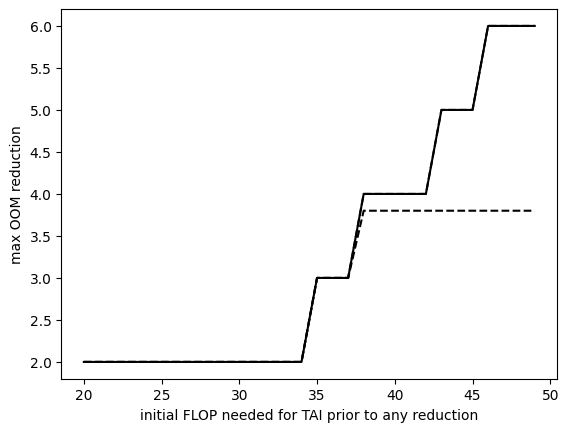

TAI log FLOP 20 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 21 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 22 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 23 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 24 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 25 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 26 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 27 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 28 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 29 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 30 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 31 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 32 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 33 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 34 -> 2.0 OOM reductions possible (

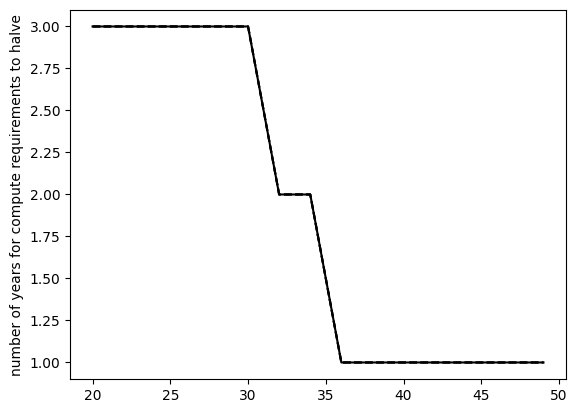

TAI log FLOP 20 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 21 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 22 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 23 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 24 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 25 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 26 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 27 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 28 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 29 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 30 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 31 -> algo doubling rate 2.5yrs (90% CI: 2.5 to 2.5)
TAI log FLOP 32 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FLOP 33 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FLOP 34 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FL

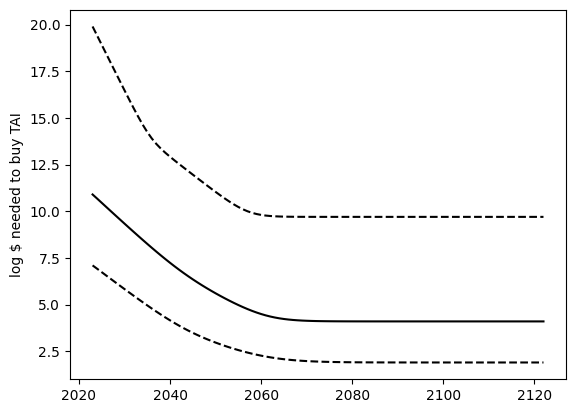

Year: 2023 - 10.9 log 2022$USD to buy TAI (~79 billion) 90% CI 7.1 (~13 million) - 19.9 (~79 quintillion)
Year: 2024 - 10.7 log 2022$USD to buy TAI (~48 billion) 90% CI 6.9 (~8 million) - 19.4 (~26 quintillion)
Year: 2025 - 10.5 log 2022$USD to buy TAI (~29 billion) 90% CI 6.7 (~5 million) - 18.9 (~8 quintillion)
Year: 2026 - 10.2 log 2022$USD to buy TAI (~17 billion) 90% CI 6.6 (~4 million) - 18.4 (~3 quintillion)
Year: 2027 - 10.0 log 2022$USD to buy TAI (~10 billion) 90% CI 6.4 (~2 million) - 17.9 (~880 quadrillion)
Year: 2028 - 9.8 log 2022$USD to buy TAI (~6 billion) 90% CI 6.2 (~2 million) - 17.5 (~286 quadrillion)
Year: 2029 - 9.6 log 2022$USD to buy TAI (~4 billion) 90% CI 6.0 (~1 million) - 17.0 (~93 quadrillion)
Year: 2030 - 9.3 log 2022$USD to buy TAI (~2 billion) 90% CI 5.8 (~683 thousand) - 16.5 (~31 quadrillion)
Year: 2031 - 9.1 log 2022$USD to buy TAI (~1 billion) 90% CI 5.7 (~453 thousand) - 16.0 (~10 quadrillion)
Year: 2032 - 8.9 log 2022$USD to buy TAI (~797 million) 

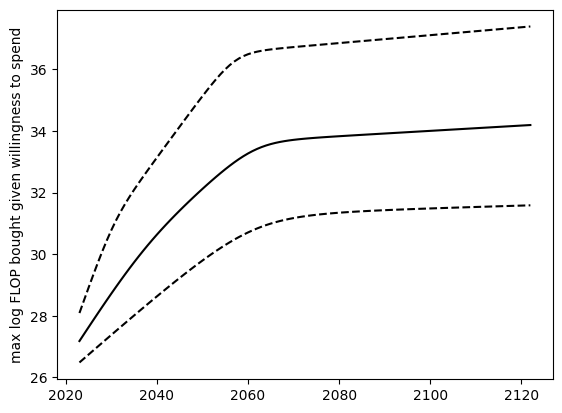

Year: 2023 - max log FLOP 27.2 (~2 octillion) 90% CI 26.5 (~305 septillion) - 28.1 (~12 octillion)
Year: 2024 - max log FLOP 27.4 (~3 octillion) 90% CI 26.6 (~410 septillion) - 28.5 (~32 octillion)
Year: 2025 - max log FLOP 27.6 (~4 octillion) 90% CI 26.7 (~552 septillion) - 28.9 (~82 octillion)
Year: 2026 - max log FLOP 27.9 (~7 octillion) 90% CI 26.9 (~741 septillion) - 29.3 (~206 octillion)
Year: 2027 - max log FLOP 28.1 (~12 octillion) 90% CI 27.0 (~994 septillion) - 29.7 (~510 octillion)
Year: 2028 - max log FLOP 28.3 (~20 octillion) 90% CI 27.1 (~1 octillion) - 30.1 (~1 nonillion)
Year: 2029 - max log FLOP 28.5 (~32 octillion) 90% CI 27.3 (~2 octillion) - 30.4 (~3 nonillion)
Year: 2030 - max log FLOP 28.7 (~53 octillion) 90% CI 27.4 (~2 octillion) - 30.8 (~6 nonillion)
Year: 2031 - max log FLOP 28.9 (~86 octillion) 90% CI 27.5 (~3 octillion) - 31.1 (~12 nonillion)
Year: 2032 - max log FLOP 29.1 (~138 octillion) 90% CI 27.6 (~4 octillion) - 31.4 (~23 nonillion)
Year: 2033 - max lo

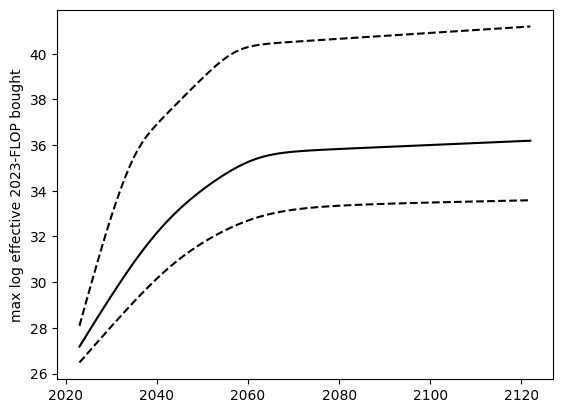

Year: 2023 - max log effective 2023-FLOP 27.2 (~2 octillion) 90% CI 26.5 (~305 septillion) - 28.1 (~12 octillion)
Year: 2024 - max log effective 2023-FLOP 27.5 (~3 octillion) 90% CI 26.7 (~511 septillion) - 28.8 (~64 octillion)
Year: 2025 - max log effective 2023-FLOP 27.8 (~7 octillion) 90% CI 26.9 (~862 septillion) - 29.5 (~326 octillion)
Year: 2026 - max log effective 2023-FLOP 28.1 (~14 octillion) 90% CI 27.2 (~1 octillion) - 30.2 (~2 nonillion)
Year: 2027 - max log effective 2023-FLOP 28.5 (~29 octillion) 90% CI 27.4 (~2 octillion) - 30.9 (~8 nonillion)
Year: 2028 - max log effective 2023-FLOP 28.8 (~60 octillion) 90% CI 27.6 (~4 octillion) - 31.6 (~39 nonillion)
Year: 2029 - max log effective 2023-FLOP 29.1 (~124 octillion) 90% CI 27.8 (~7 octillion) - 32.2 (~176 nonillion)
Year: 2030 - max log effective 2023-FLOP 29.4 (~253 octillion) 90% CI 28.1 (~12 octillion) - 32.9 (~756 nonillion)
Year: 2031 - max log effective 2023-FLOP 29.7 (~511 octillion) 90% CI 28.3 (~19 octillion) - 3

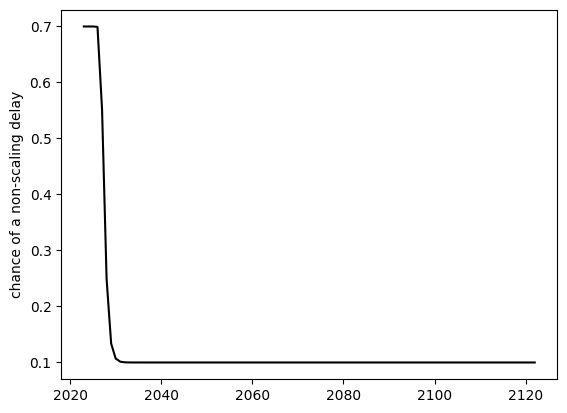

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 55%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 25%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 11%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033

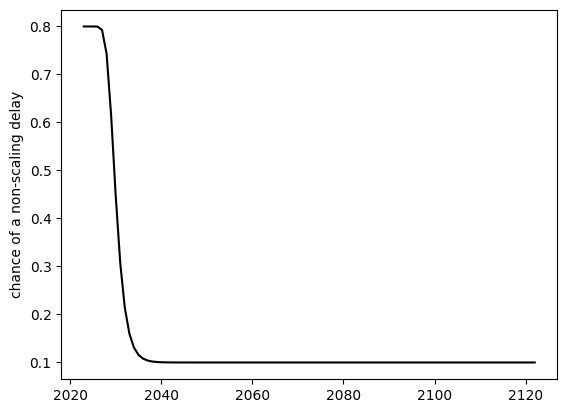

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 80%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 80%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 80%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 80%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 79%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 74%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 61%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 45%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 31%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2033

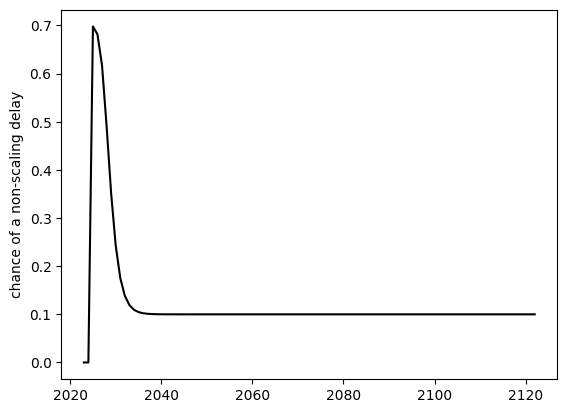

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 0%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 0%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 68%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 62%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 49%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 35%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 24%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 14%
Year: 2033 -

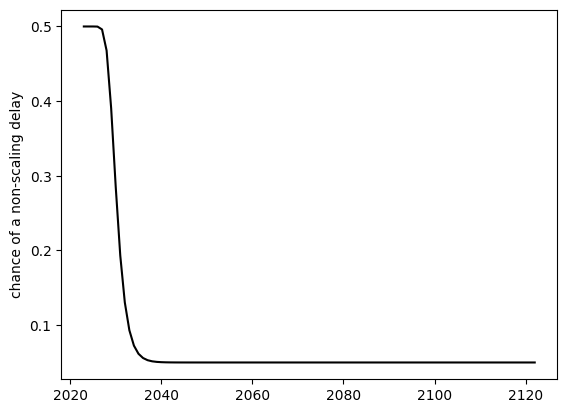

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 50%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 50%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 50%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 50%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 50%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 47%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 39%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 29%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 19%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2033

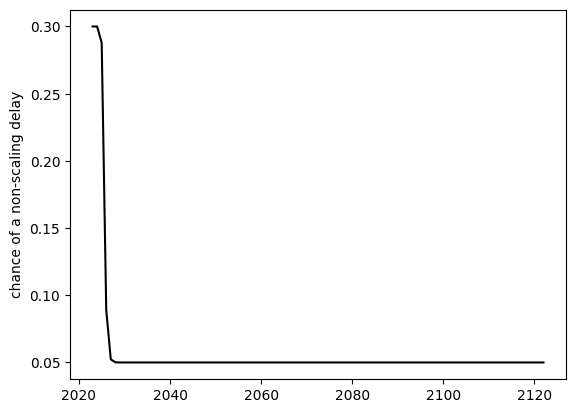

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 29%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 9%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - chan

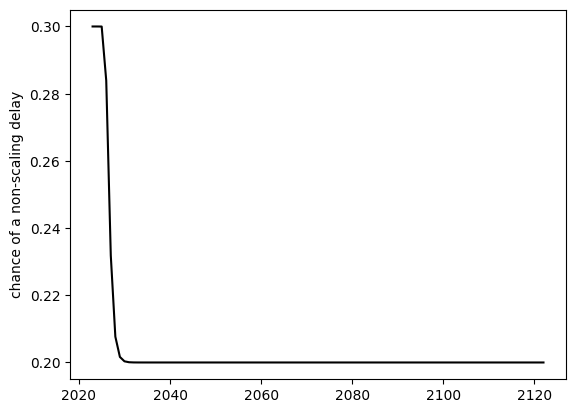

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 28%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 23%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2033

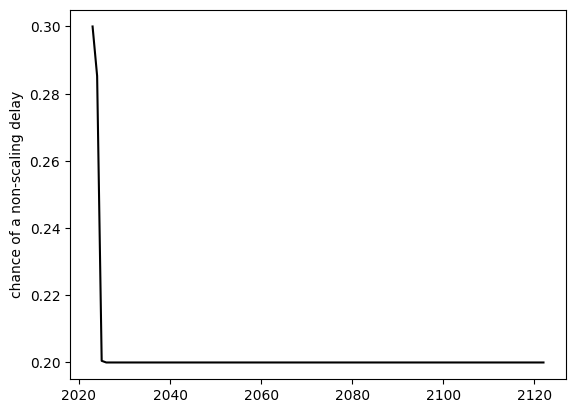

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 29%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2033

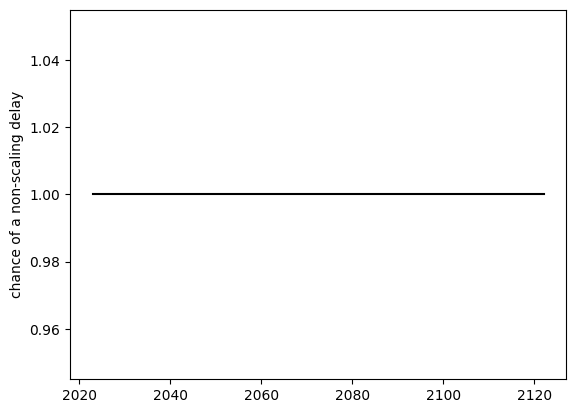

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%


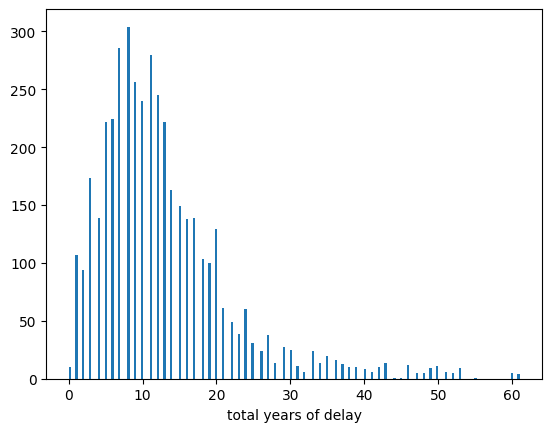

In [9]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=5,
                    runs=variables['RUNS'],
                    #dump_cache_file='caches/tai_years_metaculus_parity')
                    dump_cache_file='caches/tai_years')


-
-
## SAMPLE RUN 4 ##
It takes 27.0 log FLOP (~1 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~45 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~155 million). This doubles every 2.5 years to a max of 0.028034% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.033x per year.
---
Year: 2023 - 26.7 max log FLOP (470 septillion) available - TAI takes 27.0 log FLOP (1 octillion) - log $ 8.5 to buy TAI (322 million) vs. willingness to pay log $ 8.2 (151 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 26.7)
Year: 2024 - 26.9 max log FLOP (797 septillion) available - TAI takes 26.9 log FLOP (804 septillion) - log $ 8.3 to buy TAI (201 million) vs. willingness to pay log $ 8.3 (199 million) - 18.6 log FLOP per $ (4 quinti

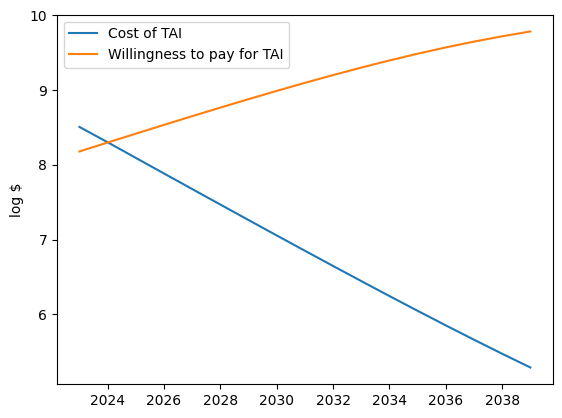

-
-
## SAMPLE RUN 5 ##
It takes 29.0 log FLOP (~100 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.8 log FLOP (~6 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~20 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~391 million). This doubles every 5.1 years to a max of 0.093601% of GDP (initially ~22 billion 2022$USD). GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 27.4 max log FLOP (2 octillion) available - TAI takes 29.0 log FLOP (100 octillion) - log $ 10.2 to buy TAI (17 billion) vs. willingness to pay log $ 8.6 (384 million) - 18.8 log FLOP per $ (6 quintillion) (Effective 2023-logFLOP: 27.4)
Year: 2024 - 27.5 max log FLOP (3 octillion) available - TAI takes 28.9 log FLOP (80 octillion) - log $ 10.0 to buy TAI (11 billion) vs. willingness to pay log $ 8.6 (439 million) - 18.9 log FLOP per $ (8 quintil

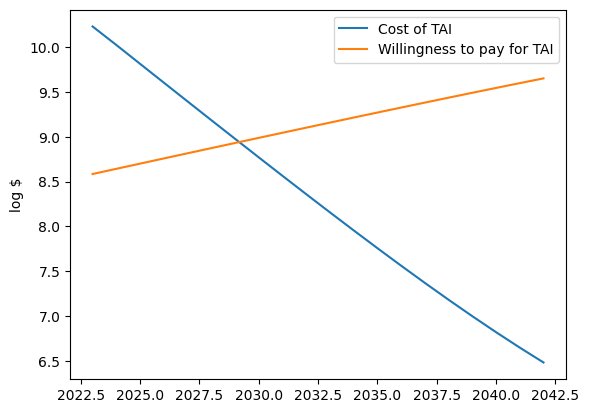

-
-
## SAMPLE RUN 6 ##
It takes 31.7 log FLOP (~50 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.9 log FLOP (~8 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 21.4 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~377 million). This doubles every 3.1 years to a max of 0.031267% of GDP (initially ~7 billion 2022$USD). GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 27.4 max log FLOP (3 octillion) available - TAI takes 31.7 log FLOP (50 nonillion) - log $ 12.8 to buy TAI (7 trillion) vs. willingness to pay log $ 8.6 (358 million) - 18.9 log FLOP per $ (8 quintillion) (Effective 2023-logFLOP: 27.4)
Year: 2024 - 27.6 max log FLOP (4 octillion) available - TAI takes 31.6 log FLOP (38 nonillion) - log $ 12.6 to buy TAI (4 trillion) vs. willingness to pay log $ 8.6 (443 million) - 19.0 log FLOP per $ (10 quintillio

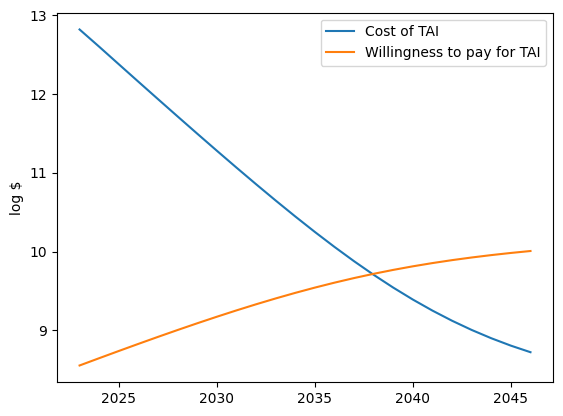

-
-
## SAMPLE RUN 7 ##
It takes 35.2 log FLOP (~158 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.5 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~688 sextillion) per 2022$USD.
We are initially willing to pay 9.1 log 2022$USD (~1 billion). This doubles every 5.2 years to a max of 0.054249% of GDP (initially ~12 billion 2022$USD). GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 27.3 max log FLOP (2 octillion) available - TAI takes 35.2 log FLOP (158 decillion) - log $ 16.9 to buy TAI (84 quadrillion) vs. willingness to pay log $ 9.0 (1 billion) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.3)
Year: 2024 - 27.6 max log FLOP (4 octillion) available - TAI takes 35.0 log FLOP (100 decillion) - log $ 16.5 to buy TAI (33 quadrillion) vs. willingness to pay log $ 9.1 (1 billion) - 18.5 log FLOP per $ (3 qui

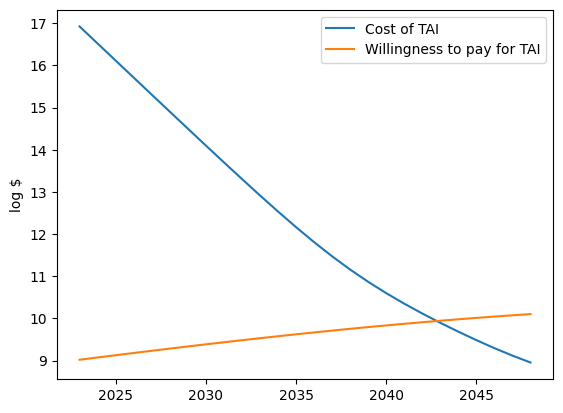

-
-
## SAMPLE RUN 8 ##
It takes 40.9 log FLOP (~79 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~5 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~175 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~698 million). This doubles every 2.6 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 27.5 max log FLOP (3 octillion) available - TAI takes 40.9 log FLOP (79 million decillion) - log $ 22.2 to buy TAI (16 sextillion) vs. willingness to pay log $ 8.8 (622 million) - 18.7 log FLOP per $ (5 quintillion) (Effective 2023-logFLOP: 27.5)
Year: 2024 - 27.8 max log FLOP (6 octillion) available - TAI takes 40.6 log FLOP (40 million decillion) - log $ 21.7 to buy TAI (5 sextillion) vs. willingness to pay log $ 8.9 (787 million) - 18.9 log

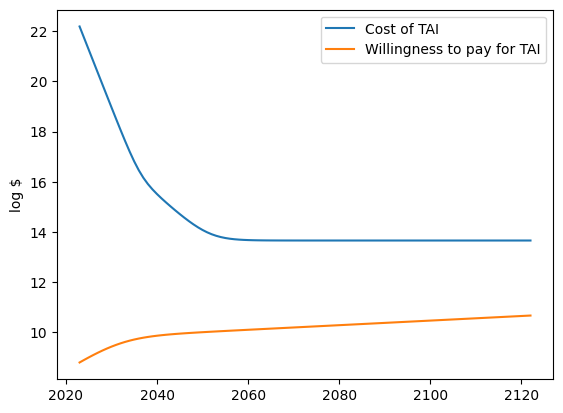

-
-
## SAMPLE RUN 9 ##
It takes 26.5 log FLOP (~316 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 24.6 log FLOP (~4 septillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~193 million). This doubles every 3.0 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 26.5 max log FLOP (344 septillion) available - TAI takes 26.5 log FLOP (316 septillion) - log $ 8.2 to buy TAI (171 million) vs. willingness to pay log $ 8.3 (187 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.5)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- data p_nonscaling_issue p=0

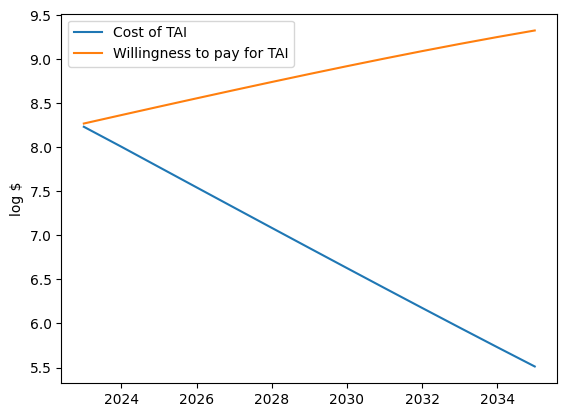

-
-
## SAMPLE RUN 10 ##
It takes 32.2 log FLOP (~158 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~5 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 21.1 log FLOP (~1 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~470 million). This doubles every 5.3 years to a max of 0.032328% of GDP (initially ~7 billion 2022$USD). GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 27.4 max log FLOP (2 octillion) available - TAI takes 32.2 log FLOP (158 nonillion) - log $ 13.5 to buy TAI (29 trillion) vs. willingness to pay log $ 8.6 (442 million) - 18.7 log FLOP per $ (5 quintillion) (Effective 2023-logFLOP: 27.4)
Year: 2024 - 27.6 max log FLOP (4 octillion) available - TAI takes 32.1 log FLOP (114 nonillion) - log $ 13.2 to buy TAI (15 trillion) vs. willingness to pay log $ 8.7 (500 million) - 18.9 log FLOP per $ (8 quint

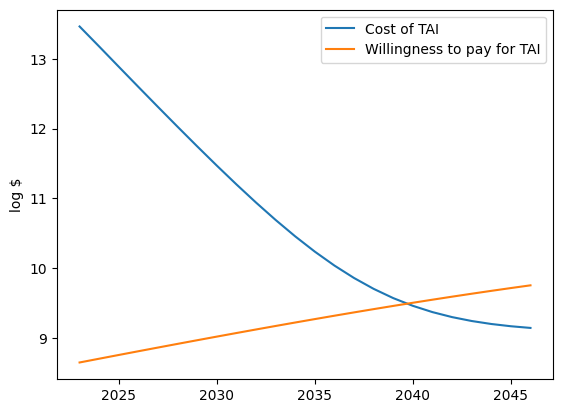

-
-
## SAMPLE RUN 11 ##
It takes 30.8 log FLOP (~6 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.4 log FLOP (~3 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 20.8 log FLOP (~629 quintillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~246 million). This doubles every 10.7 years to a max of 0.056371% of GDP (initially ~13 billion 2022$USD). GDP grows at a rate of 1.011x per year.
---
Year: 2023 - 26.8 max log FLOP (674 septillion) available - TAI takes 30.8 log FLOP (6 nonillion) - log $ 12.4 to buy TAI (2 trillion) vs. willingness to pay log $ 8.4 (242 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.0 max log FLOP (913 septillion) available - TAI takes 30.7 log FLOP (5 nonillion) - log $ 12.1 to buy TAI (1 trillion) vs. willingness to pay log $ 8.4 (258 million) - 18.5 log FLOP per $ (4 qu

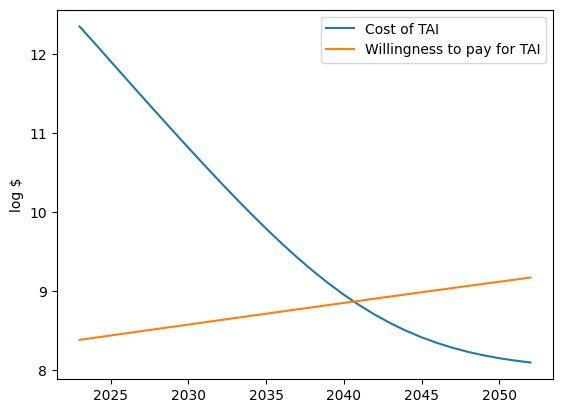

-
-
## SAMPLE RUN 12 ##
It takes 43.6 log FLOP (~40 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.4 log FLOP (~3 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~171 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~197 million). This doubles every 3.0 years to a max of 0.064298% of GDP (initially ~15 billion 2022$USD). GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 26.7 max log FLOP (525 septillion) available - TAI takes 43.6 log FLOP (40 billion decillion) - log $ 25.2 to buy TAI (15 septillion) vs. willingness to pay log $ 8.3 (194 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 26.7)
Year: 2024 - 26.9 max log FLOP (849 septillion) available - TAI takes 43.3 log FLOP (20 billion decillion) - log $ 24.8 to buy TAI (6 septillion) vs. willingness to pay log $ 8.4 (243 million)

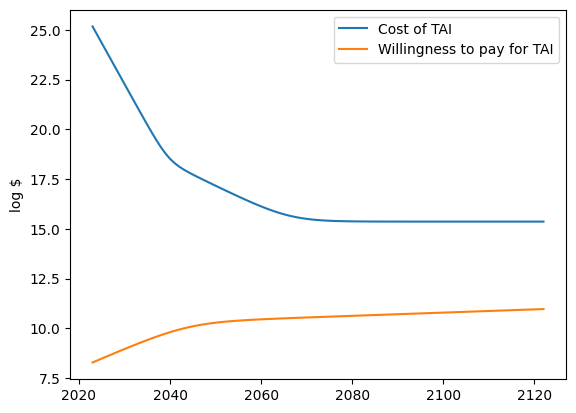

-
-
## SAMPLE RUN 13 ##
It takes 26.6 log FLOP (~398 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.1 log FLOP (~14 quintillion) per 2022$USD. Every 3.8 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~51 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~601 million). This doubles every 2.5 years to a max of 0.054741% of GDP (initially ~13 billion 2022$USD). GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 27.9 max log FLOP (8 octillion) available - TAI takes 26.6 log FLOP (398 septillion) - log $ 7.5 to buy TAI (29 million) vs. willingness to pay log $ 8.8 (573 million) - 19.1 log FLOP per $ (14 quintillion) (Effective 2023-logFLOP: 27.9)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 6 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 2 years (to

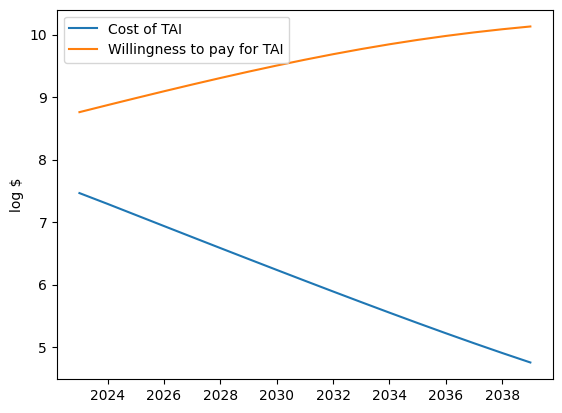

-
-
## SAMPLE RUN 14 ##
It takes 40.0 log FLOP (~10 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.6 log FLOP (~4 septillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~241 million). This doubles every 2.1 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.036x per year.
---
Year: 2023 - 26.9 max log FLOP (862 septillion) available - TAI takes 40.0 log FLOP (10 million decillion) - log $ 21.4 to buy TAI (3 sextillion) vs. willingness to pay log $ 8.4 (231 million) - 18.6 log FLOP per $ (4 quintillion) (Effective 2023-logFLOP: 26.9)
Year: 2024 - 27.2 max log FLOP (2 octillion) available - TAI takes 39.7 log FLOP (5 million decillion) - log $ 21.0 to buy TAI (1 sextillion) vs. willingness to pay log $ 8.5 (318 million) - 18.7 log

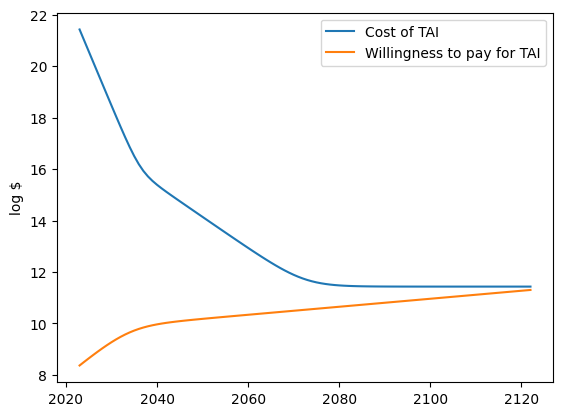

-
-
## SAMPLE RUN 15 ##
It takes 27.4 log FLOP (~3 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~6 quintillion) per 2022$USD. Every 1.6 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~427 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~241 million). This doubles every 7.8 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.012x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 27.4 log FLOP (3 octillion) - log $ 8.7 to buy TAI (452 million) vs. willingness to pay log $ 8.4 (231 million) - 18.7 log FLOP per $ (6 quintillion) (Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 27.3 log FLOP (2 octillion) - log $ 8.4 to buy TAI (233 million) vs. willingness to pay log $ 8.4 (252 million) - 18.9 log FLOP per $ (9 quintillion) (Ef

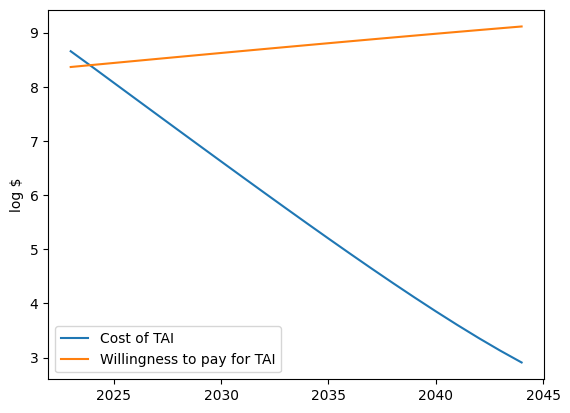

-
-
## SAMPLE RUN 16 ##
It takes 26.3 log FLOP (~200 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~6 quintillion) per 2022$USD. Every 1.8 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~235 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~378 million). This doubles every 13.1 years to a max of 0.031816% of GDP (initially ~7 billion 2022$USD). GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 27.3 max log FLOP (2 octillion) available - TAI takes 26.3 log FLOP (200 septillion) - log $ 7.6 to buy TAI (36 million) vs. willingness to pay log $ 8.6 (359 million) - 18.7 log FLOP per $ (6 quintillion) (Effective 2023-logFLOP: 27.3)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 4 years (tot

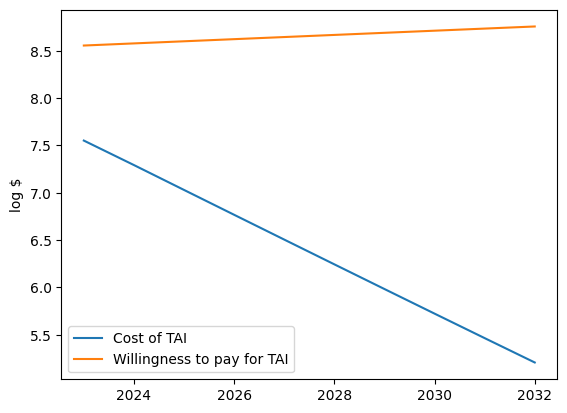

-
-
## SAMPLE RUN 17 ##
It takes 35.3 log FLOP (~200 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.8 log FLOP (~6 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~53 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~463 million). This doubles every 1.0 years until 2025, and then doubles every 0.9 years to a max of 0.026221% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 27.4 max log FLOP (2 octillion) available - TAI takes 35.3 log FLOP (200 decillion) - log $ 16.5 to buy TAI (35 quadrillion) vs. willingness to pay log $ 8.6 (430 million) - 18.8 log FLOP per $ (6 quintillion) (Effective 2023-logFLOP: 27.4)
Year: 2024 - 27.8 max log FLOP (6 octillion) available - TAI takes 35.1 log FLOP (126 decillion) - log $ 16.2 to buy TAI (18 quadrillion) vs. willingness to pay lo

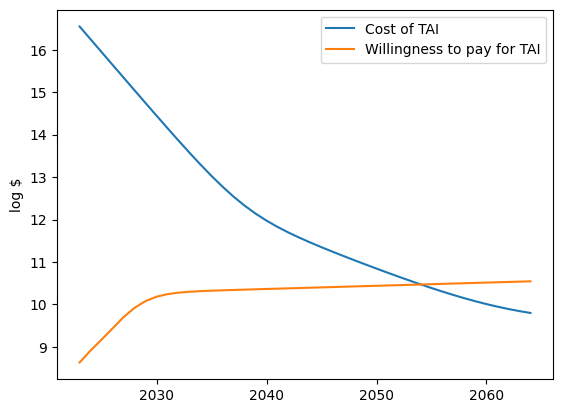

-
-
## SAMPLE RUN 18 ##
It takes 25.2 log FLOP (~16 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.8 log FLOP (~6 quintillion) per 2022$USD. Every 1.8 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~62 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~600 million). This doubles every 4.5 years to a max of 0.053215% of GDP (initially ~12 billion 2022$USD). GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 27.5 max log FLOP (3 octillion) available - TAI takes 25.2 log FLOP (16 septillion) - log $ 6.4 to buy TAI (3 million) vs. willingness to pay log $ 8.8 (572 million) - 18.8 log FLOP per $ (6 quintillion) (Effective 2023-logFLOP: 27.5)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- data p_nonscaling_issue p=0

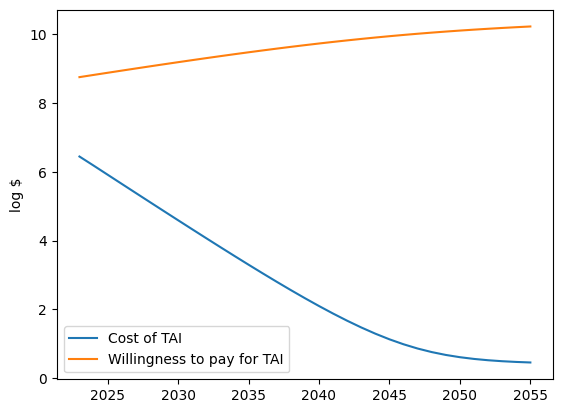

-
-
## SAMPLE RUN 19 ##
It takes 24.3 log FLOP (~2 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~7 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~614 million). This doubles every 1.8 years to a max of 0.098796% of GDP (initially ~23 billion 2022$USD). GDP grows at a rate of 1.012x per year.
---
Year: 2023 - 27.2 max log FLOP (2 octillion) available - TAI takes 24.3 log FLOP (2 septillion) - log $ 5.8 to buy TAI (693 thousand) vs. willingness to pay log $ 8.8 (598 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.2)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0

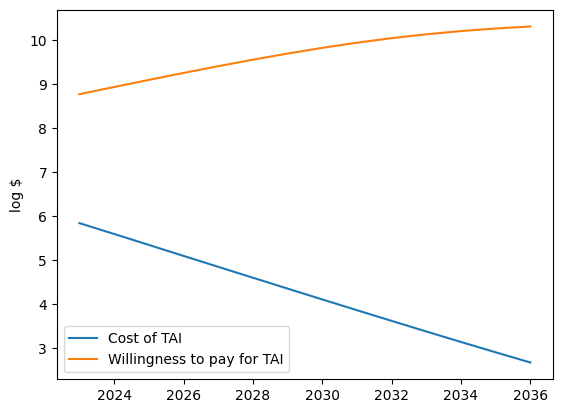

-
-
## SAMPLE RUN 20 ##
It takes 23.6 log FLOP (~398 sextillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.0 log FLOP (~11 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 20.8 log FLOP (~649 quintillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~248 million). This doubles every 1.4 years to a max of 0.073728% of GDP (initially ~17 billion 2022$USD). GDP grows at a rate of 1.032x per year.
---
Year: 2023 - 27.4 max log FLOP (3 octillion) available - TAI takes 23.6 log FLOP (398 sextillion) - log $ 4.6 to buy TAI (38 thousand) vs. willingness to pay log $ 8.4 (244 million) - 19.0 log FLOP per $ (11 quintillion) (Effective 2023-logFLOP: 27.4)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 4 years 

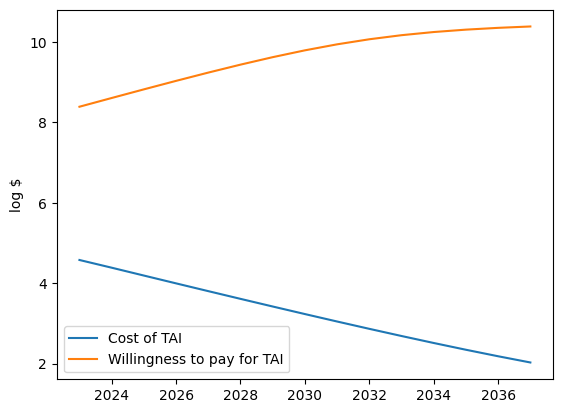

-
-
## SAMPLE RUN 21 ##
It takes 37.1 log FLOP (~13 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 19.1 log FLOP (~14 quintillion) per 2022$USD. Every 3.2 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~33 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~372 million). This doubles every 3.0 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 27.7 max log FLOP (5 octillion) available - TAI takes 37.1 log FLOP (13 thousand decillion) - log $ 18.0 to buy TAI (908 quadrillion) vs. willingness to pay log $ 8.5 (350 million) - 19.1 log FLOP per $ (14 quintillion) (Effective 2023-logFLOP: 27.7)
Year: 2024 - 27.9 max log FLOP (7 octillion) available - TAI takes 36.8 log FLOP (6 thousand decillion) - log $ 17.6 to buy TAI (366 quadrillion) vs. willingness to pay log $ 8.6 (435 million)

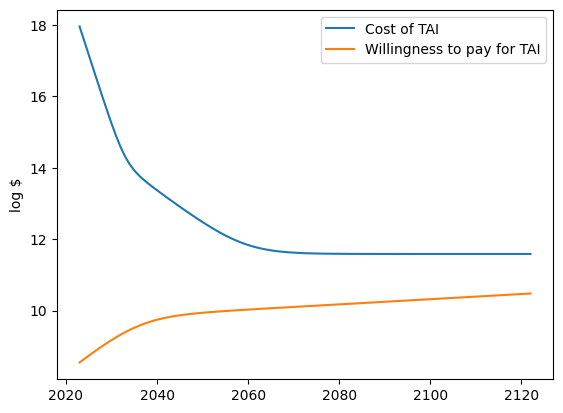

-
-
## SAMPLE RUN 22 ##
It takes 35.7 log FLOP (~501 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.1 log FLOP (~1 quintillion) per 2022$USD. Every 1.7 years they get 2x cheaper, to a maximum of 21.3 log FLOP (~2 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~194 million). This doubles every 3.2 years to a max of 0.029418% of GDP (initially ~7 billion 2022$USD). GDP grows at a rate of 1.032x per year.
---
Year: 2023 - 26.3 max log FLOP (221 septillion) available - TAI takes 35.7 log FLOP (501 decillion) - log $ 17.6 to buy TAI (428 quadrillion) vs. willingness to pay log $ 8.3 (188 million) - 18.1 log FLOP per $ (1 quintillion) (Effective 2023-logFLOP: 26.3)
Year: 2024 - 26.6 max log FLOP (405 septillion) available - TAI takes 35.5 log FLOP (316 decillion) - log $ 17.3 to buy TAI (181 quadrillion) vs. willingness to pay log $ 8.4 (232 million) - 18.2 log FLOP 

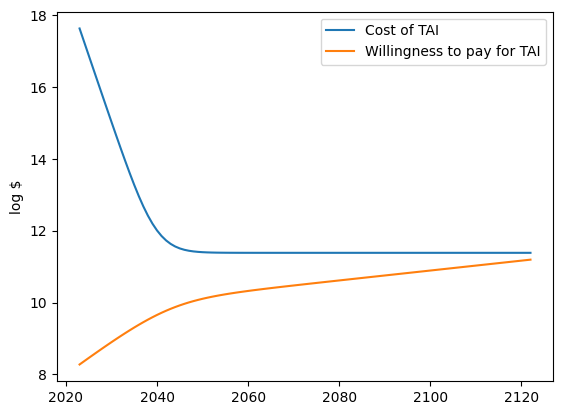

-
-
## SAMPLE RUN 23 ##
It takes 26.5 log FLOP (~316 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~664 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~473 million). This doubles every 16.5 years to a max of 0.03633% of GDP (initially ~8 billion 2022$USD). GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 27.0 max log FLOP (948 septillion) available - TAI takes 26.5 log FLOP (316 septillion) - log $ 8.2 to buy TAI (149 million) vs. willingness to pay log $ 8.7 (448 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.0)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 3 years (

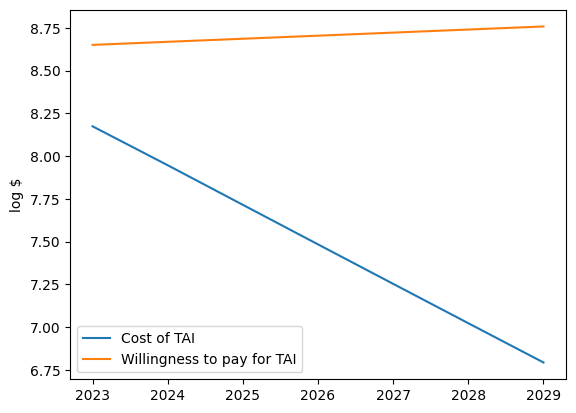

-
-
## SAMPLE RUN 24 ##
It takes 26.8 log FLOP (~631 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.1 log FLOP (~13 quintillion) per 2022$USD. Every 3.9 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~174 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~710 million). This doubles every 2.7 years to a max of 0.029159% of GDP (initially ~7 billion 2022$USD). GDP grows at a rate of 1.013x per year.
---
Year: 2023 - 27.9 max log FLOP (9 octillion) available - TAI takes 26.8 log FLOP (631 septillion) - log $ 7.7 to buy TAI (47 million) vs. willingness to pay log $ 8.8 (642 million) - 19.1 log FLOP per $ (13 quintillion) (Effective 2023-logFLOP: 27.9)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- data p_nonscaling_issu

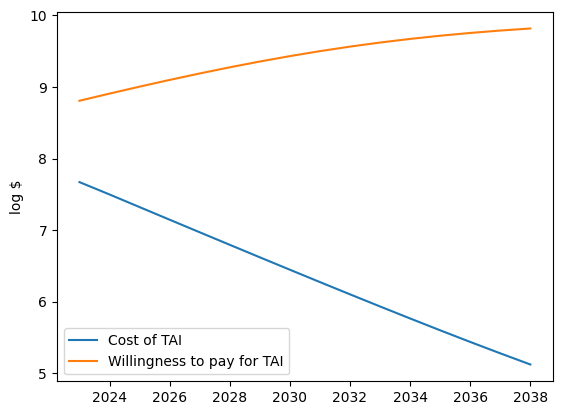

-
-
## SAMPLE RUN 25 ##
It takes 26.8 log FLOP (~631 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 17.9 log FLOP (~860 quadrillion) per 2022$USD. Every 4.7 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1 septillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~481 million). This doubles every 1.7 years to a max of 0.052691% of GDP (initially ~12 billion 2022$USD). GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 26.6 max log FLOP (398 septillion) available - TAI takes 26.8 log FLOP (631 septillion) - log $ 8.9 to buy TAI (734 million) vs. willingness to pay log $ 8.7 (463 million) - 17.9 log FLOP per $ (860 quadrillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.8 max log FLOP (679 septillion) available - TAI takes 26.7 log FLOP (507 septillion) - log $ 8.7 to buy TAI (508 million) vs. willingness to pay log $ 8.8 (680 million) - 18.0 log FLOP per 

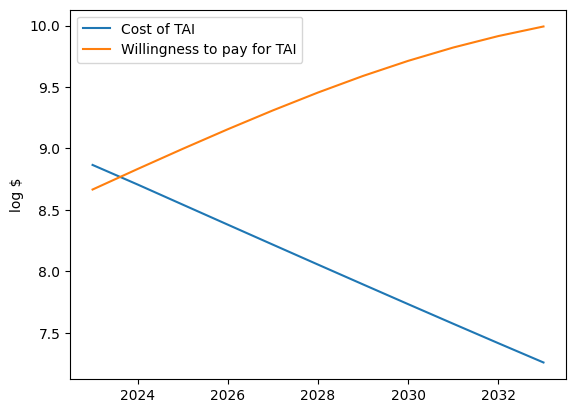

-
-
## SAMPLE RUN 26 ##
It takes 28.1 log FLOP (~13 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.2 log FLOP (~2 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 24.4 log FLOP (~3 septillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~381 million). This doubles every 3.3 years to a max of 0.037995% of GDP (initially ~9 billion 2022$USD). GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 26.8 max log FLOP (596 septillion) available - TAI takes 28.1 log FLOP (13 octillion) - log $ 9.9 to buy TAI (8 billion) vs. willingness to pay log $ 8.6 (365 million) - 18.2 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.0 max log FLOP (1 octillion) available - TAI takes 28.0 log FLOP (10 octillion) - log $ 9.6 to buy TAI (4 billion) vs. willingness to pay log $ 8.6 (446 million) - 18.4 log FLOP per $ (2 quintillion

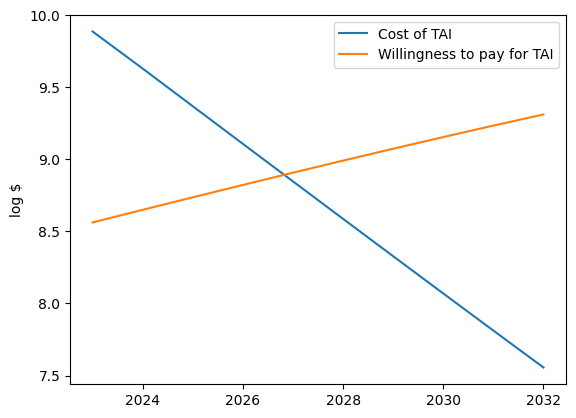

-
-
## SAMPLE RUN 27 ##
It takes 30.7 log FLOP (~5 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~5 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~246 million). This doubles every 2.8 years to a max of 0.052299% of GDP (initially ~12 billion 2022$USD). GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 27.0 max log FLOP (961 septillion) available - TAI takes 30.7 log FLOP (5 nonillion) - log $ 12.1 to buy TAI (1 trillion) vs. willingness to pay log $ 8.4 (241 million) - 18.6 log FLOP per $ (4 quintillion) (Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.2 max log FLOP (2 octillion) available - TAI takes 30.6 log FLOP (4 nonillion) - log $ 11.9 to buy TAI (749 billion) vs. willingness to pay log $ 8.5 (307 million) - 18.7 log FLOP per $ (5 quintill

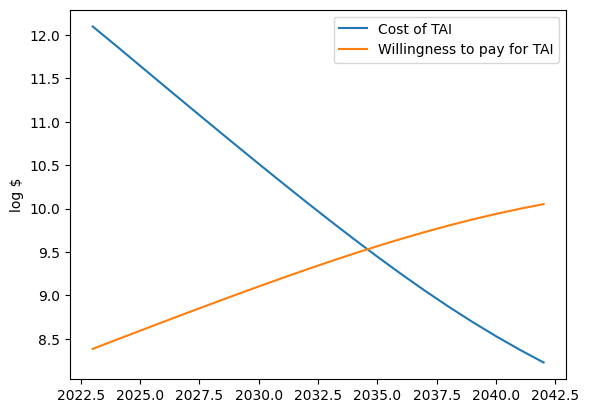

-
-
## SAMPLE RUN 28 ##
It takes 37.0 log FLOP (~10 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 19.0 log FLOP (~10 quintillion) per 2022$USD. Every 3.4 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~55 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~710 million). This doubles every 1.4 years to a max of 0.029252% of GDP (initially ~7 billion 2022$USD). GDP grows at a rate of 1.015x per year.
---
Year: 2023 - 27.8 max log FLOP (6 octillion) available - TAI takes 37.0 log FLOP (10 thousand decillion) - log $ 18.0 to buy TAI (1 quintillion) vs. willingness to pay log $ 8.8 (643 million) - 19.0 log FLOP per $ (10 quintillion) (Effective 2023-logFLOP: 27.8)
Year: 2024 - 28.1 max log FLOP (12 octillion) available - TAI takes 36.7 log FLOP (5 thousand decillion) - log $ 17.6 to buy TAI (417 quadrillion) vs. willingness to pay log $ 9.0 (986 millio

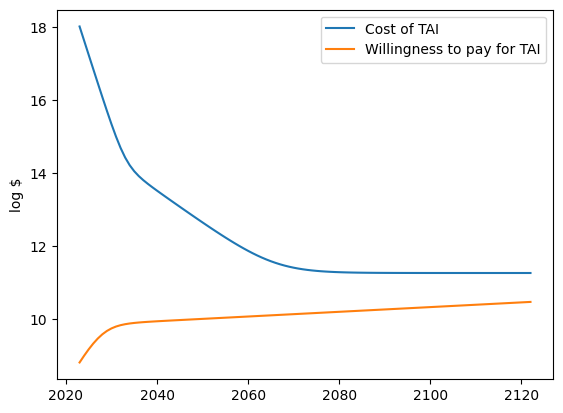

-
-
## SAMPLE RUN 29 ##
It takes 24.8 log FLOP (~6 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.7 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~44 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~469 million). This doubles every 3.1 years to a max of 0.031381% of GDP (initially ~7 billion 2022$USD). GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 27.0 max log FLOP (944 septillion) available - TAI takes 24.8 log FLOP (6 septillion) - log $ 6.5 to buy TAI (3 million) vs. willingness to pay log $ 8.6 (440 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.0)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- data p_nonscaling_issue p=0

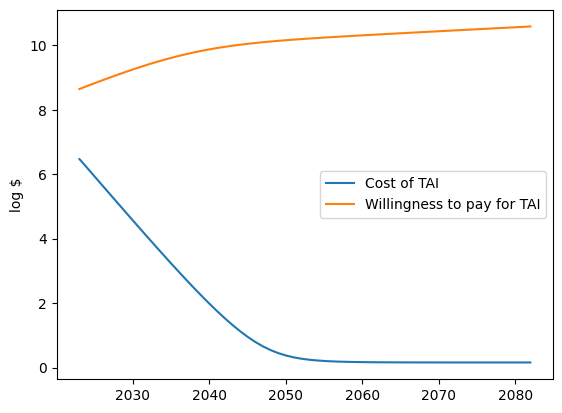

-
-
## SAMPLE RUN 30 ##
It takes 30.9 log FLOP (~8 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 19.6 log FLOP (~39 quintillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~157 million). This doubles every 2.3 years to a max of 0.073209% of GDP (initially ~17 billion 2022$USD). GDP grows at a rate of 1.014x per year.
---
Year: 2023 - 26.8 max log FLOP (567 septillion) available - TAI takes 30.9 log FLOP (8 nonillion) - log $ 12.3 to buy TAI (2 trillion) vs. willingness to pay log $ 8.2 (156 million) - 18.6 log FLOP per $ (4 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.0 max log FLOP (970 septillion) available - TAI takes 30.8 log FLOP (6 nonillion) - log $ 12.1 to buy TAI (1 trillion) vs. willingness to pay log $ 8.3 (209 million) - 18.7 log FLOP per $ (5 quin

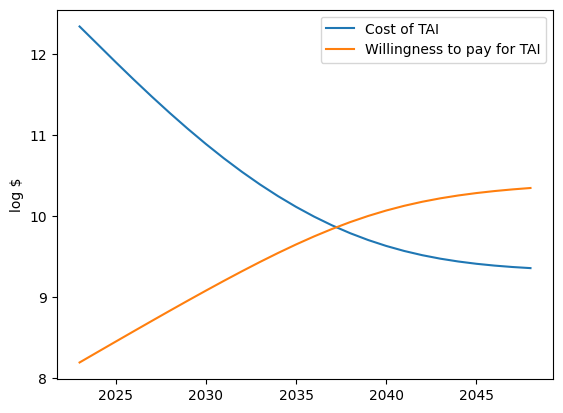

-
-
## SAMPLE RUN 31 ##
It takes 29.5 log FLOP (~316 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~6 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~196 million). This doubles every 2.0 years to a max of 0.05629% of GDP (initially ~13 billion 2022$USD). GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 26.8 max log FLOP (658 septillion) available - TAI takes 29.5 log FLOP (316 octillion) - log $ 11.0 to buy TAI (93 billion) vs. willingness to pay log $ 8.3 (194 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 29.4 log FLOP (254 octillion) - log $ 10.7 to buy TAI (55 billion) vs. willingness to pay log $ 8.4 (271 million) - 18.7 log FLOP per $ (5 quin

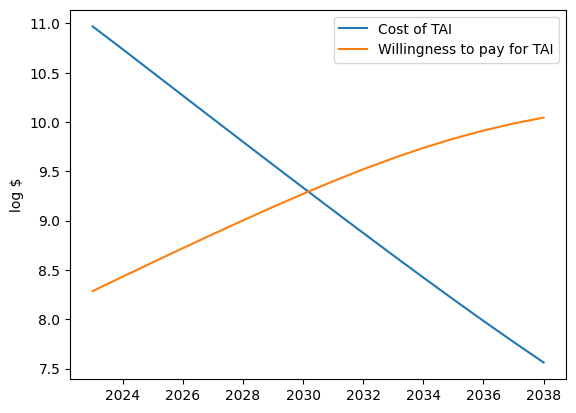

-
-
## SAMPLE RUN 32 ##
It takes 25.8 log FLOP (~63 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 24.4 log FLOP (~3 septillion) per 2022$USD.
We are initially willing to pay 9.0 log 2022$USD (~933 million). This doubles every 2.7 years to a max of 0.060725% of GDP (initially ~14 billion 2022$USD). GDP grows at a rate of 1.035x per year.
---
Year: 2023 - 27.6 max log FLOP (4 octillion) available - TAI takes 25.8 log FLOP (63 septillion) - log $ 7.2 to buy TAI (15 million) vs. willingness to pay log $ 8.9 (875 million) - 18.6 log FLOP per $ (4 quintillion) (Effective 2023-logFLOP: 27.6)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0

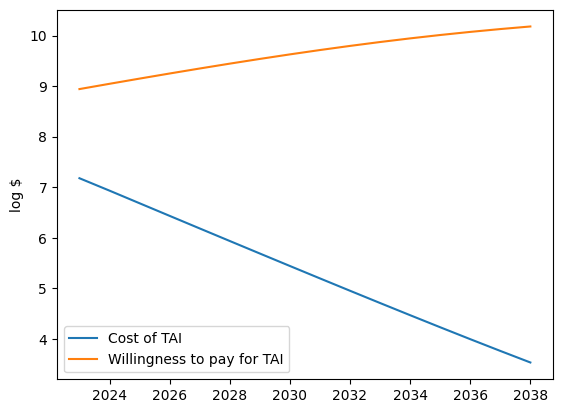

-
-
## SAMPLE RUN 33 ##
It takes 37.8 log FLOP (~63 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.8 log FLOP (~7 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 25.0 log FLOP (~10 septillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~627 million). This doubles every 1.7 years to a max of 0.412755% of GDP (initially ~95 billion 2022$USD). GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 27.6 max log FLOP (4 octillion) available - TAI takes 37.8 log FLOP (63 thousand decillion) - log $ 19.0 to buy TAI (9 quintillion) vs. willingness to pay log $ 8.8 (623 million) - 18.8 log FLOP per $ (7 quintillion) (Effective 2023-logFLOP: 27.6)
Year: 2024 - 27.9 max log FLOP (9 octillion) available - TAI takes 37.5 log FLOP (32 thousand decillion) - log $ 18.5 to buy TAI (3 quintillion) vs. willingness to pay log $ 9.0 (924 million) 

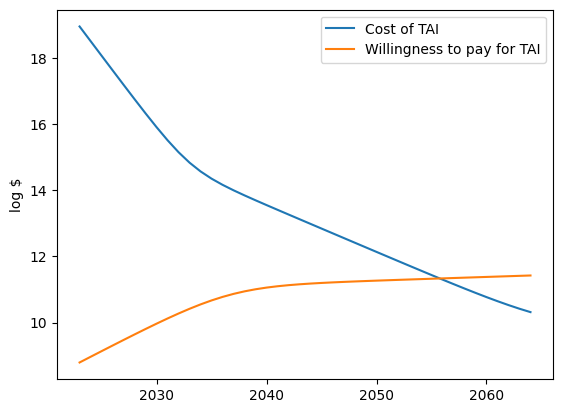

-
-
## SAMPLE RUN 34 ##
It takes 24.2 log FLOP (~2 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~86 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~603 million). This doubles every 2.3 years to a max of 0.058887% of GDP (initially ~14 billion 2022$USD). GDP grows at a rate of 1.032x per year.
---
Year: 2023 - 27.3 max log FLOP (2 octillion) available - TAI takes 24.2 log FLOP (2 septillion) - log $ 5.6 to buy TAI (435 thousand) vs. willingness to pay log $ 8.8 (577 million) - 18.6 log FLOP per $ (4 quintillion) (Effective 2023-logFLOP: 27.3)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 8 years (total delay 8 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 2 years (total 

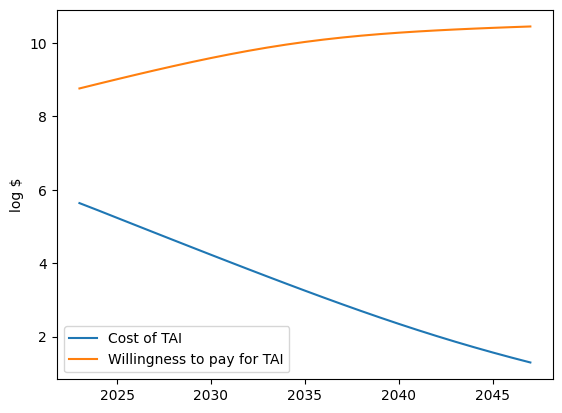

-
-
## SAMPLE RUN 35 ##
It takes 33.8 log FLOP (~6 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.4 log FLOP (~3 quintillion) per 2022$USD. Every 4.4 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~6 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~372 million). This doubles every 3.3 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 27.0 max log FLOP (953 septillion) available - TAI takes 33.8 log FLOP (6 decillion) - log $ 15.4 to buy TAI (2 quadrillion) vs. willingness to pay log $ 8.5 (350 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 33.7 log FLOP (5 decillion) - log $ 15.2 to buy TAI (1 quadrillion) vs. willingness to pay log $ 8.6 (425 million) - 18.5 log FLOP per $ (3 quintil

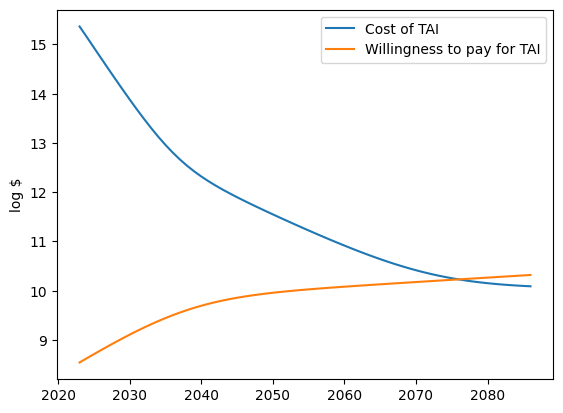

-
-
## SAMPLE RUN 36 ##
It takes 28.6 log FLOP (~40 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~341 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~372 million). This doubles every 1.1 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.033x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 28.6 log FLOP (40 octillion) - log $ 10.0 to buy TAI (11 billion) vs. willingness to pay log $ 8.5 (350 million) - 18.6 log FLOP per $ (4 quintillion) (Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.5 max log FLOP (3 octillion) available - TAI takes 28.5 log FLOP (32 octillion) - log $ 9.8 to buy TAI (7 billion) vs. willingness to pay log $ 8.8 (628 million) - 18.7 log FLOP per $ (5 quintillion) 

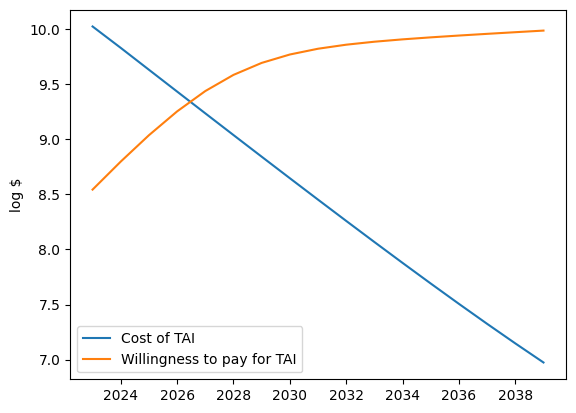

-
-
## SAMPLE RUN 37 ##
It takes 24.2 log FLOP (~2 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~5 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 25.0 log FLOP (~9 septillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~196 million). This doubles every 4.5 years to a max of 0.046369% of GDP (initially ~11 billion 2022$USD). GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 27.0 max log FLOP (1 octillion) available - TAI takes 24.2 log FLOP (2 septillion) - log $ 5.5 to buy TAI (290 thousand) vs. willingness to pay log $ 8.3 (192 million) - 18.7 log FLOP per $ (5 quintillion) (Effective 2023-logFLOP: 27.0)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 6 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0

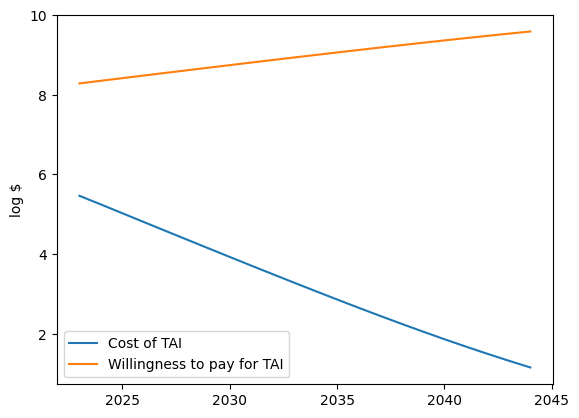

-
-
## SAMPLE RUN 38 ##
It takes 26.9 log FLOP (~794 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.1 log FLOP (~14 quintillion) per 2022$USD. Every 3.8 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~75 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~197 million). This doubles every 3.7 years to a max of 0.068431% of GDP (initially ~16 billion 2022$USD). GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 27.4 max log FLOP (3 octillion) available - TAI takes 26.9 log FLOP (794 septillion) - log $ 7.8 to buy TAI (57 million) vs. willingness to pay log $ 8.3 (195 million) - 19.1 log FLOP per $ (14 quintillion) (Effective 2023-logFLOP: 27.4)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 1 years (total delay 1 years)
-- data p_nonscaling_issu

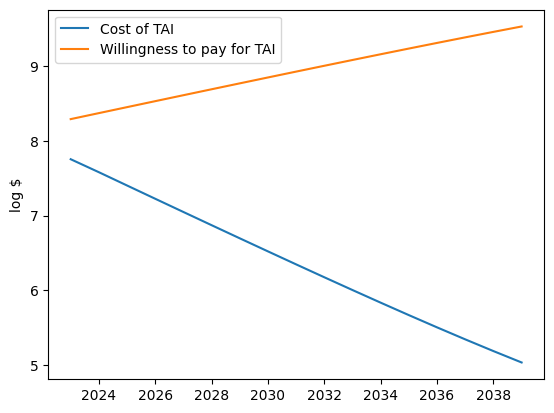

-
-
## SAMPLE RUN 39 ##
It takes 23.7 log FLOP (~501 sextillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.1 log FLOP (~1 quintillion) per 2022$USD. Every 1.8 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~18 sextillion) per 2022$USD.
We are initially willing to pay 9.0 log 2022$USD (~935 million). This doubles every 5.4 years to a max of 0.062634% of GDP (initially ~14 billion 2022$USD). GDP grows at a rate of 1.032x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 23.7 log FLOP (501 sextillion) - log $ 5.6 to buy TAI (389 thousand) vs. willingness to pay log $ 8.9 (878 million) - 18.1 log FLOP per $ (1 quintillion) (Effective 2023-logFLOP: 27.1)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 3 years (to

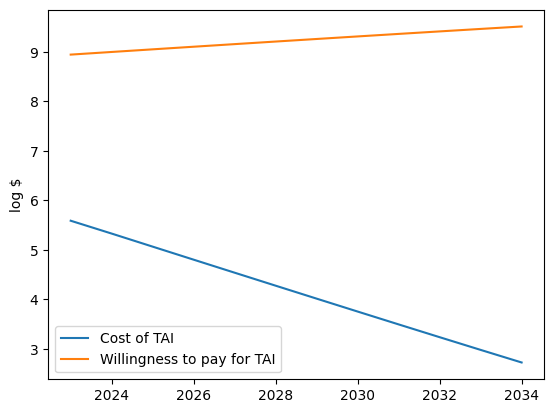

-
-
## SAMPLE RUN 40 ##
It takes 43.9 log FLOP (~79 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~190 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~372 million). This doubles every 0.9 years until 2025, and then doubles every 0.9 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.8 max log FLOP (635 septillion) available - TAI takes 43.9 log FLOP (79 billion decillion) - log $ 25.6 to buy TAI (44 septillion) vs. willingness to pay log $ 8.5 (350 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 43.6 log FLOP (40 billion decillion) - log $ 25.2 to buy TAI (15 septillion) vs. wil

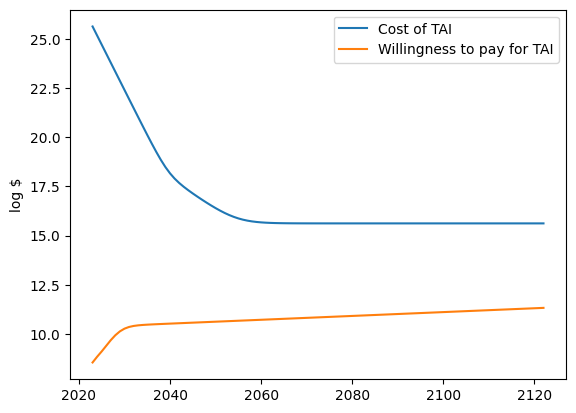

-
-
## SAMPLE RUN 41 ##
It takes 26.5 log FLOP (~316 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.1 log FLOP (~1 quintillion) per 2022$USD. Every 3.2 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1 septillion) per 2022$USD.
We are initially willing to pay 9.3 log 2022$USD (~2 billion). This doubles every 1.6 years to a max of 0.113397% of GDP (initially ~26 billion 2022$USD). GDP grows at a rate of 1.016x per year.
---
Year: 2023 - 27.3 max log FLOP (2 octillion) available - TAI takes 26.5 log FLOP (316 septillion) - log $ 8.4 to buy TAI (278 million) vs. willingness to pay log $ 9.2 (2 billion) - 18.1 log FLOP per $ (1 quintillion) (Effective 2023-logFLOP: 27.3)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 2 years (total de

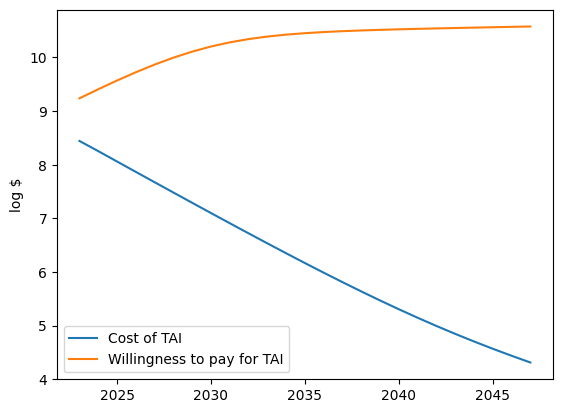

-
-
## SAMPLE RUN 42 ##
It takes 26.1 log FLOP (~126 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.9 log FLOP (~9 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~10 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~300 million). This doubles every 6.8 years to a max of 0.025933% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 27.4 max log FLOP (2 octillion) available - TAI takes 26.1 log FLOP (126 septillion) - log $ 7.2 to buy TAI (15 million) vs. willingness to pay log $ 8.5 (286 million) - 18.9 log FLOP per $ (9 quintillion) (Effective 2023-logFLOP: 27.4)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p

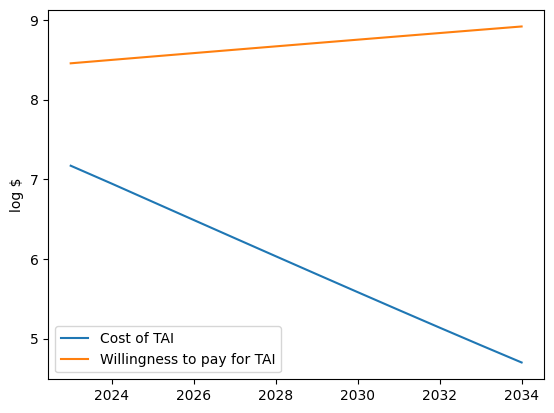

-
-
## SAMPLE RUN 43 ##
It takes 33.3 log FLOP (~2 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 3.5 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~73 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~484 million). This doubles every 2.7 years to a max of 0.061203% of GDP (initially ~14 billion 2022$USD). GDP grows at a rate of 1.016x per year.
---
Year: 2023 - 27.2 max log FLOP (2 octillion) available - TAI takes 33.3 log FLOP (2 decillion) - log $ 14.7 to buy TAI (550 trillion) vs. willingness to pay log $ 8.7 (468 million) - 18.6 log FLOP per $ (4 quintillion) (Effective 2023-logFLOP: 27.2)
Year: 2024 - 27.4 max log FLOP (3 octillion) available - TAI takes 33.2 log FLOP (1 decillion) - log $ 14.5 to buy TAI (323 trillion) vs. willingness to pay log $ 8.8 (599 million) - 18.6 log FLOP per $ (4 quintil

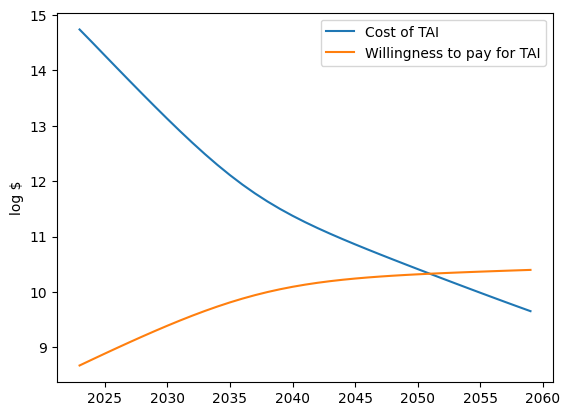

-
-
## SAMPLE RUN 44 ##
It takes 32.7 log FLOP (~501 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~5 quintillion) per 2022$USD. Every 1.2 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~339 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~461 million). This doubles every 4.1 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.014x per year.
---
Year: 2023 - 27.3 max log FLOP (2 octillion) available - TAI takes 32.7 log FLOP (501 nonillion) - log $ 14.0 to buy TAI (100 trillion) vs. willingness to pay log $ 8.6 (427 million) - 18.7 log FLOP per $ (5 quintillion) (Effective 2023-logFLOP: 27.3)
Year: 2024 - 27.6 max log FLOP (4 octillion) available - TAI takes 32.6 log FLOP (359 nonillion) - log $ 13.6 to buy TAI (40 trillion) vs. willingness to pay log $ 8.7 (500 million) - 19.0 log FLOP per $ (9 quint

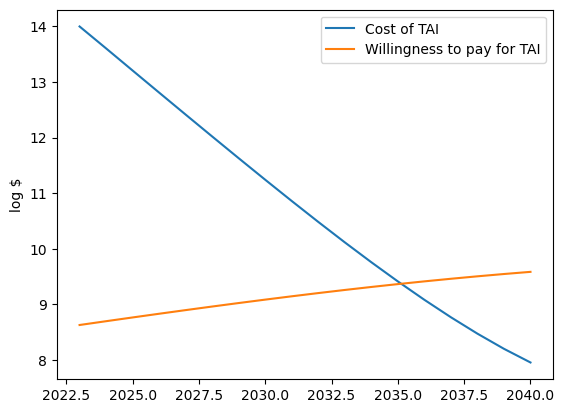

-
-
## SAMPLE RUN 45 ##
It takes 26.9 log FLOP (~794 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.9 log FLOP (~8 quintillion) per 2022$USD. Every 3.4 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~107 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~98 million). This doubles every 4.6 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 26.9 max log FLOP (758 septillion) available - TAI takes 26.9 log FLOP (794 septillion) - log $ 8.0 to buy TAI (101 million) vs. willingness to pay log $ 8.0 (97 million) - 18.9 log FLOP per $ (8 quintillion) (Effective 2023-logFLOP: 26.9)
Year: 2024 - 27.0 max log FLOP (1 octillion) available - TAI takes 26.8 log FLOP (638 septillion) - log $ 7.8 to buy TAI (66 million) vs. willingness to pay log $ 8.0 (112 million) - 19.0 log FLOP per $ (10 quinti

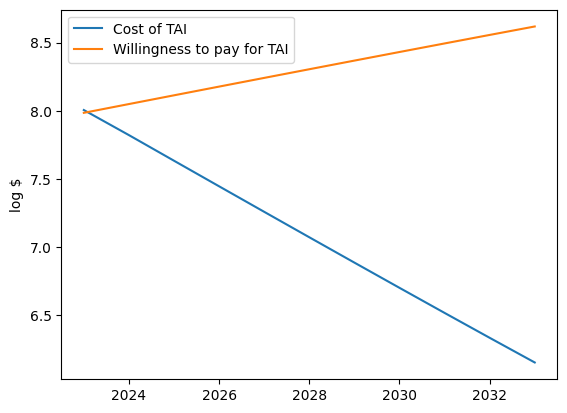

-
-
## SAMPLE RUN 46 ##
It takes 25.8 log FLOP (~63 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~5 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 23.7 log FLOP (~507 sextillion) per 2022$USD.
We are initially willing to pay 9.2 log 2022$USD (~2 billion). This doubles every 1.0 years until 2025, and then doubles every 0.9 years to a max of 0.050992% of GDP (initially ~12 billion 2022$USD). GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 27.9 max log FLOP (7 octillion) available - TAI takes 25.8 log FLOP (63 septillion) - log $ 7.1 to buy TAI (13 million) vs. willingness to pay log $ 9.2 (1 billion) - 18.7 log FLOP per $ (5 quintillion) (Effective 2023-logFLOP: 27.9)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay o

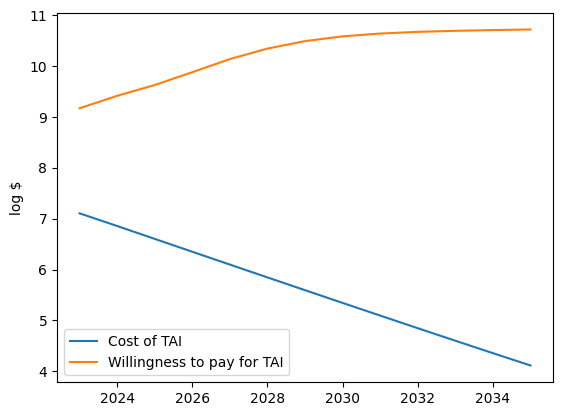

-
-
## SAMPLE RUN 47 ##
It takes 28.9 log FLOP (~79 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.7 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~102 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~478 million). This doubles every 3.5 years to a max of 0.044416% of GDP (initially ~10 billion 2022$USD). GDP grows at a rate of 1.011x per year.
---
Year: 2023 - 27.0 max log FLOP (1 octillion) available - TAI takes 28.9 log FLOP (79 octillion) - log $ 10.6 to buy TAI (36 billion) vs. willingness to pay log $ 8.7 (456 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 28.8 log FLOP (64 octillion) - log $ 10.3 to buy TAI (19 billion) vs. willingness to pay log $ 8.7 (553 million) - 18.5 log FLOP per $ (3 quintil

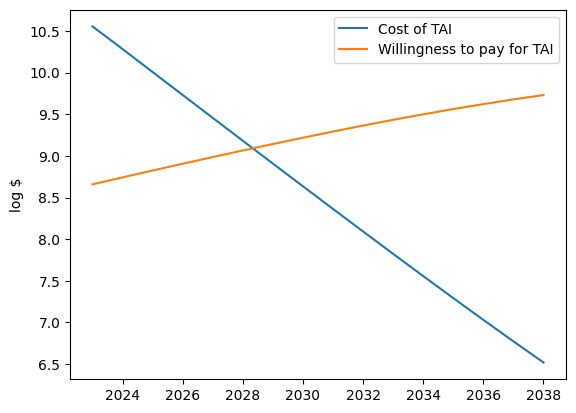

-
-
## SAMPLE RUN 48 ##
It takes 26.2 log FLOP (~158 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.1 log FLOP (~12 quintillion) per 2022$USD. Every 1.3 years they get 2x cheaper, to a maximum of 25.8 log FLOP (~63 septillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~242 million). This doubles every 1.6 years to a max of 0.028121% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.015x per year.
---
Year: 2023 - 27.4 max log FLOP (3 octillion) available - TAI takes 26.2 log FLOP (158 septillion) - log $ 7.1 to buy TAI (13 million) vs. willingness to pay log $ 8.4 (233 million) - 19.1 log FLOP per $ (12 quintillion) (Effective 2023-logFLOP: 27.4)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not occur
-- 

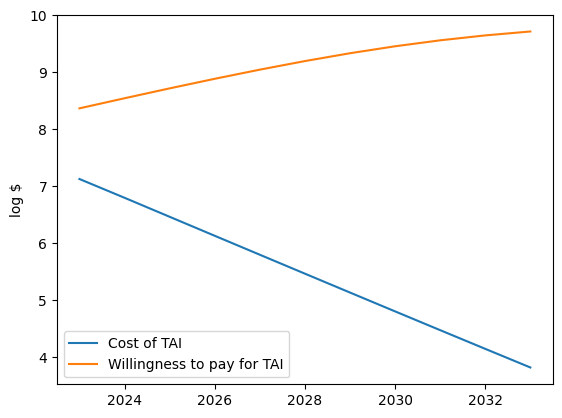

-
-
## SAMPLE RUN 49 ##
It takes 34.1 log FLOP (~13 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 19.0 log FLOP (~11 quintillion) per 2022$USD. Every 1.6 years they get 2x cheaper, to a maximum of 20.7 log FLOP (~514 quintillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~378 million). This doubles every 1.4 years to a max of 0.031763% of GDP (initially ~7 billion 2022$USD). GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 27.6 max log FLOP (4 octillion) available - TAI takes 34.1 log FLOP (13 decillion) - log $ 15.1 to buy TAI (1 quadrillion) vs. willingness to pay log $ 8.6 (359 million) - 19.0 log FLOP per $ (11 quintillion) (Effective 2023-logFLOP: 27.6)
Year: 2024 - 28.0 max log FLOP (10 octillion) available - TAI takes 33.9 log FLOP (8 decillion) - log $ 14.7 to buy TAI (483 trillion) vs. willingness to pay log $ 8.8 (581 million) - 19.2 log FLOP per $ (16

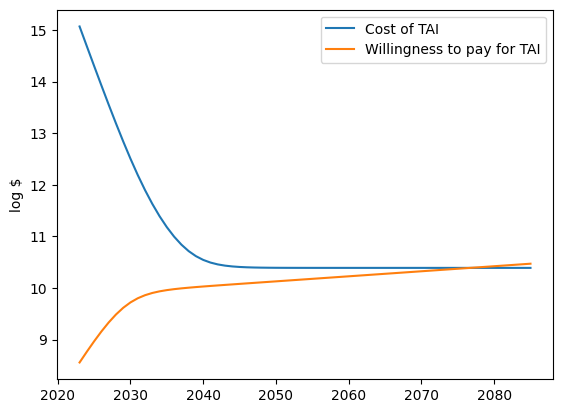

-
-
## SAMPLE RUN 50 ##
It takes 27.2 log FLOP (~2 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 24.4 log FLOP (~3 septillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~244 million). This doubles every 3.1 years to a max of 0.036624% of GDP (initially ~8 billion 2022$USD). GDP grows at a rate of 1.016x per year.
---
Year: 2023 - 27.0 max log FLOP (1 octillion) available - TAI takes 27.2 log FLOP (2 octillion) - log $ 8.6 to buy TAI (368 million) vs. willingness to pay log $ 8.4 (237 million) - 18.6 log FLOP per $ (4 quintillion) (Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.2 max log FLOP (2 octillion) available - TAI takes 27.1 log FLOP (1 octillion) - log $ 8.3 to buy TAI (219 million) vs. willingness to pay log $ 8.5 (295 million) - 18.8 log FLOP per $ (6 quintillion) (E

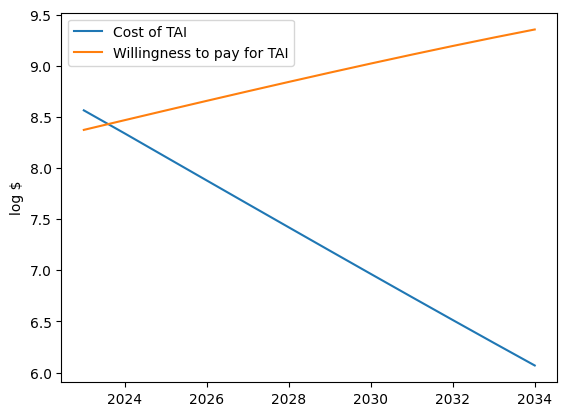

-
-
## SAMPLE RUN 51 ##
It takes 30.5 log FLOP (~3 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.0 log FLOP (~11 quintillion) per 2022$USD. Every 1.6 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~2 septillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~623 million). This doubles every 2.2 years to a max of 0.224778% of GDP (initially ~52 billion 2022$USD). GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 27.8 max log FLOP (7 octillion) available - TAI takes 30.5 log FLOP (3 nonillion) - log $ 11.5 to buy TAI (296 billion) vs. willingness to pay log $ 8.8 (616 million) - 19.0 log FLOP per $ (11 quintillion) (Effective 2023-logFLOP: 27.8)
Year: 2024 - 28.1 max log FLOP (14 octillion) available - TAI takes 30.4 log FLOP (2 nonillion) - log $ 11.2 to buy TAI (149 billion) vs. willingness to pay log $ 8.9 (838 million) - 19.2 log FLOP per $ (16 quintil

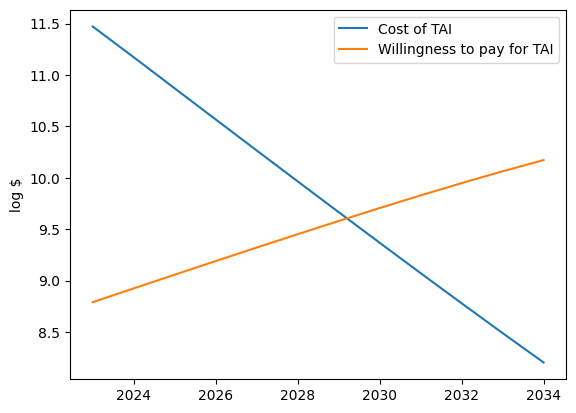

-
-
## SAMPLE RUN 52 ##
It takes 26.8 log FLOP (~631 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~408 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~372 million). This doubles every 10.2 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 26.8 log FLOP (631 septillion) - log $ 8.2 to buy TAI (171 million) vs. willingness to pay log $ 8.5 (350 million) - 18.6 log FLOP per $ (4 quintillion) (Effective 2023-logFLOP: 27.1)
-- algorithms p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- data p_nonscaling_issue p

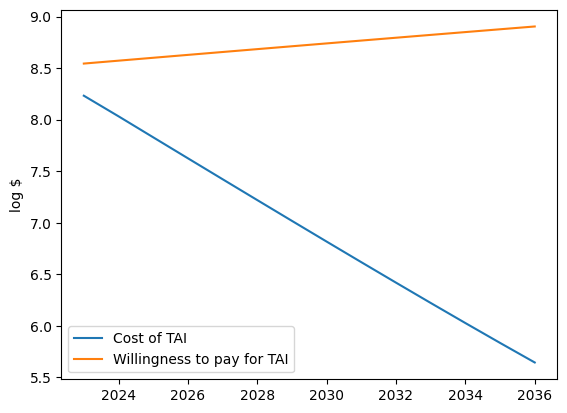

-
-
## SAMPLE RUN 53 ##
It takes 37.1 log FLOP (~13 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.4 log FLOP (~3 quintillion) per 2022$USD. Every 1.8 years they get 2x cheaper, to a maximum of 25.9 log FLOP (~81 septillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~783 million). This doubles every 1.9 years to a max of 0.244667% of GDP (initially ~56 billion 2022$USD). GDP grows at a rate of 1.012x per year.
---
Year: 2023 - 27.3 max log FLOP (2 octillion) available - TAI takes 37.1 log FLOP (13 thousand decillion) - log $ 18.7 to buy TAI (5 quintillion) vs. willingness to pay log $ 8.9 (773 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.3)
Year: 2024 - 27.6 max log FLOP (4 octillion) available - TAI takes 36.8 log FLOP (6 thousand decillion) - log $ 18.2 to buy TAI (2 quintillion) vs. willingness to pay log $ 9.0 (1 billion) - 1

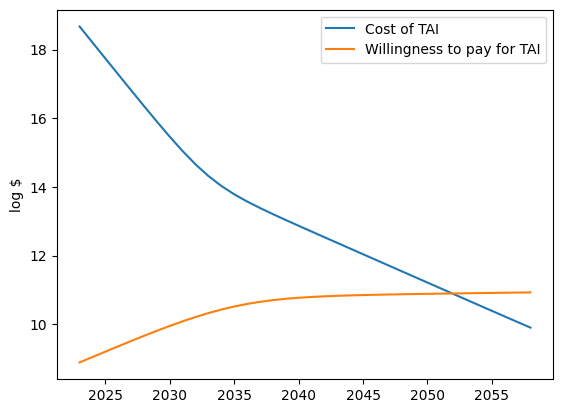

In [10]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(variables, verbose=True)

In [11]:
print('File last ran: {}'.format(dt.now()))

File last ran: 2023-09-05 17:40:02.899004
